### Blog Post Must-Haves

Your blog post should include everything from how you identified what tables contained the information you need, to how you retrieved it using SQL (and any challenges you ran into while doing so), as well as your methodology and results for your hypothesis tests. 

**_NOTE:_**  This blog post is your way of showcasing the work you've done on this project--chances are it will soon be read by a recruiter or hiring manager! Take the time to make sure that you craft your story well, and clearly explain your process and findings in a way that clearly shows both your technical expertise **_and_** your ability to communicate your results!

### Executive Summary Must-Haves

Your presentation should:

* Contain between 5-10 professional quality slides detailing:
<br>  
    * A high-level overview of your methodology  
    <br>  
    * The results of your hypothesis tests  
    <br>  
    * Any real-world recommendations you would like to make based on your findings (ask yourself--why should the executive team care about what you found? How can your findings help the company?)  
    <br>  
* Take no more than 5 minutes to present   

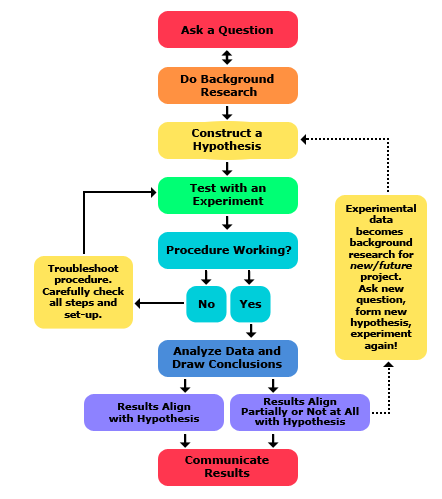#Scientific Method Image

First the necessary libraries are imported:

In [1]:
import pandas as pd
import numpy as np
import sqlalchemy
import sqlite3 as sql
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import datetime as dt
import scipy.stats

from sqlalchemy import create_engine, inspect
from sqlalchemy.orm import Session, sessionmaker
from sqlalchemy import MetaData
from sqlalchemy.ext.automap import automap_base

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn import preprocessing
from statsmodels.formula.api import ols
from scipy import stats
from sklearn import linear_model as lm
from statsmodels.graphics.factorplots import interaction_plot
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison

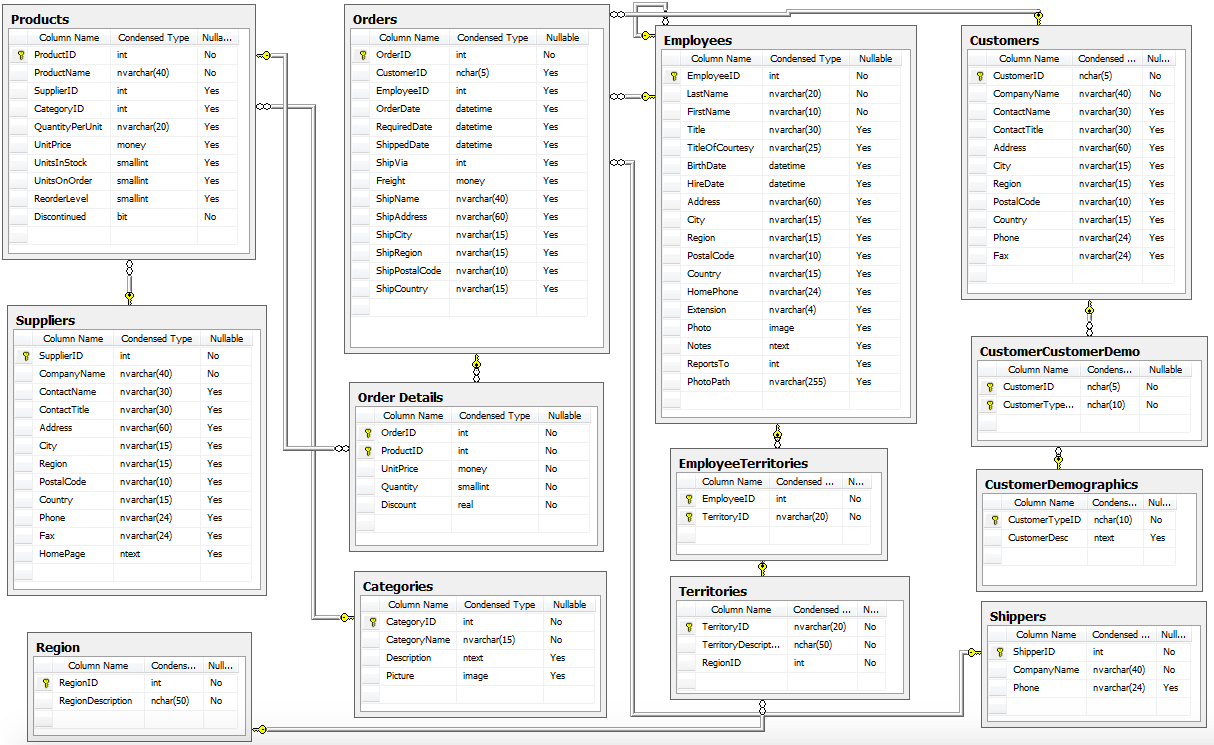#Image of Northwind_ERD

First, I'll connect to the Northwind Traders database.

In [2]:
engine = create_engine('sqlite:///Northwind_small.sqlite',echo=True)
Session = sessionmaker(bind=engine)
session = Session()
inspector = inspect(engine)
#print(inspector.get_table_names())

2019-03-25 08:24:10,169 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-03-25 08:24:10,170 INFO sqlalchemy.engine.base.Engine ()
2019-03-25 08:24:10,173 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-03-25 08:24:10,174 INFO sqlalchemy.engine.base.Engine ()


Next, I'll print the table names.

In [3]:
conn=sql.connect("Northwind_small.sqlite")
cur=conn.cursor()
table_names=list(cur.execute('''SELECT name FROM sqlite_master WHERE TYPE = 'table' ''').fetchall())
print(table_names)

[('Employee',), ('Category',), ('Customer',), ('Shipper',), ('Supplier',), ('Order',), ('Product',), ('OrderDetail',), ('CustomerCustomerDemo',), ('CustomerDemographic',), ('Region',), ('Territory',), ('EmployeeTerritory',)]


Let's inspect the column names on one of the tables.

In [4]:
def get_columns_info(col_name):
    cols_list = inspector.get_columns(col_name)
    print("Table Name: {}".format(col_name))
    print("")
    for column in cols_list:
        print("Name: {} \t Type: {}".format(column['name'],column['type']))

get_columns_info('Order')

2019-03-25 08:24:14,656 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Order")
2019-03-25 08:24:14,657 INFO sqlalchemy.engine.base.Engine ()
Table Name: Order

Name: Id 	 Type: INTEGER
Name: CustomerId 	 Type: VARCHAR(8000)
Name: EmployeeId 	 Type: INTEGER
Name: OrderDate 	 Type: VARCHAR(8000)
Name: RequiredDate 	 Type: VARCHAR(8000)
Name: ShippedDate 	 Type: VARCHAR(8000)
Name: ShipVia 	 Type: INTEGER
Name: Freight 	 Type: DECIMAL
Name: ShipName 	 Type: VARCHAR(8000)
Name: ShipAddress 	 Type: VARCHAR(8000)
Name: ShipCity 	 Type: VARCHAR(8000)
Name: ShipRegion 	 Type: VARCHAR(8000)
Name: ShipPostalCode 	 Type: VARCHAR(8000)
Name: ShipCountry 	 Type: VARCHAR(8000)


There are discrepancies in the table names.  Most of the table names are singular and the ERD show plural table names.  Here are the table names where there's a difference:  "Category", "Customer", "CustomerDemographic", "Employee", "EmployeeTerritory", "Order", "OrderDetail", "Product", "Shipper", "Supplier", "Territory".

Each table name will be stored in a Pandas DataFrame.  Through a trial and error process, In this project, I found that this was easier to work with and analyze.  

The use of table merges and queries in Pandas instead of SQL was a major decision point for me.  I am comfortable using both and did use both in this project.  

In [5]:
Employee=pd.read_sql_query('''SELECT * FROM Employee''',conn)
Category=pd.read_sql_query('''SELECT * FROM Category''',conn)
Customer=pd.read_sql_query('''SELECT * FROM Customer''',conn)
Shipper=pd.read_sql_query('''SELECT * FROM Shipper''',conn)
Supplier=pd.read_sql_query('''SELECT * FROM Supplier''',conn)
Order = pd.read_sql_query('''SELECT * FROM [Order]''', conn)
Product=pd.read_sql_query('''SELECT * FROM Product''',conn)
OrderDetail=pd.read_sql_query('''SELECT * FROM OrderDetail''',conn)
CustomerCustomerDemo=pd.read_sql_query('''SELECT * FROM CustomerCustomerDemo''',conn)
CustomerDemographic=pd.read_sql_query('''SELECT * FROM CustomerDemographic''',conn)
Region=pd.read_sql_query('''SELECT * FROM Region''',conn)
Territory=pd.read_sql_query('''SELECT * FROM Territory''',conn)
EmployeeTerritory=pd.read_sql_query('''SELECT * FROM EmployeeTerritory''',conn)

In [ ]:
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

QUESTION 1:  DO DISCOUNTS HAVE A STATISTICALLY SIGNIFICANT AFFECT ON THE NUMBER OF PRODUCTS CUSTOMERS ORDER?  IF SO, AT WHAT LEVEL(S) OF DISCOUNT?  

    -NULL HYPOTHESES:  The average quantity of product sold in the same for orders with or without a discount.
    
    -ALTERNATIVE HYPOTHESIS:  The average quantity of product sold with a discount is higher than product sold without a discount.
        
    -ONE-TAIL TEST and ALPHA = .05

This will require a one-tail test, because the business is interested if a discount will statistically increase sales.  If the null hypothesis is rejected, then there is a statistically significant increase in the quantity of products sold with discounts.  

To test the hypothesis, we will be using the table 'OrderDetails' and looking at the columns 'Quantity' and 'Discount'.  Below we can see that there are no NaN nor missing values in either column.  Also, 'Quantity' ranges from 1 to 130 and 'Discount' ranges form 0 to .25.

In [6]:
OrderDetail.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [7]:
OrderDetail.describe()

,OrderId,ProductId,UnitPrice,Quantity,Discount
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,40.793039,26.218520,23.812993,0.056167
std,241.378032,22.159019,29.827418,19.022047,0.083450
min,10248.000000,1.000000,2.000000,1.000000,0.000000
25%,10451.000000,22.000000,12.000000,10.000000,0.000000
50%,10657.000000,41.000000,18.400000,20.000000,0.000000
75%,10862.500000,60.000000,32.000000,30.000000,0.100000
max,11077.000000,77.000000,263.500000,130.000000,0.250000


Text(0, 0.5, 'Average Quantity')

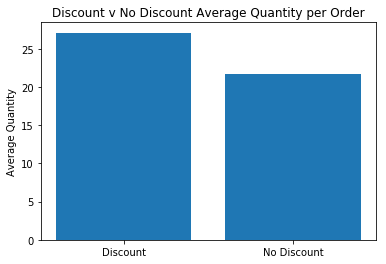

In [8]:
X=['Discount','No Discount']
Y=OrderDetail['Quantity'][OrderDetail["Discount"]>0].mean(), OrderDetail['Quantity'][OrderDetail["Discount"]==0].mean()
plt.bar(X,Y)
plt.title('Discount v No Discount Average Quantity per Order')
plt.ylabel('Average Quantity')
                            

Now the OrderDetails will be split into 2 sets.  

In [9]:
discounted_orders=OrderDetail[OrderDetail["Discount"]>0]
discounted_orders.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
6,10250/51,10250,51,42.4,35,0.15
7,10250/65,10250,65,16.8,15,0.15
8,10251/22,10251,22,16.8,6,0.05
9,10251/57,10251,57,15.6,15,0.05
11,10252/20,10252,20,64.8,40,0.05


In [10]:
non_sale_orders=OrderDetail[OrderDetail["Discount"]==0]
non_sale_orders.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [11]:
print('The Discounted Orders Mean and Median are {} and {}, respectively.  The Non-Discounted Orders Mean and Median \
are {}, and {}, respectively'.\
format(round(discounted_orders.Quantity.mean(),1),discounted_orders.Quantity.median(),\
round(non_sale_orders.Quantity.mean(),1),non_sale_orders.Quantity.median()))

The Discounted Orders Mean and Median are 27.1 and 20.0, respectively.  The Non-Discounted Orders Mean and Median are 21.7, and 18.0, respectively


Now a Ttest will be run on the 2 different samples to see if they are statistically from the same set.  A 2 Sample Ttest is used because we have two samples. 

In [11]:
pvalue=stats.ttest_ind(non_sale_orders.Quantity,discounted_orders.Quantity)
pvalue

Ttest_indResult(statistic=-6.4785631962949015, pvalue=1.1440924523215966e-10)

The above test is a two-sided ttest, so we take pvalue/2 for a one-sided test.  Our resulting pvalue is still < our alpha (.05), so this is an indication that we will REJECT THE NULL HYPOTHESIS.

Next, let's calculate Effect Size for the Discount v Non-Discount using Cohen's D.  It's the most commonly used measure of Effect Size.  I'll use it to measure the difference between Discount and Non-Discount.  A large value will represent a significant difference.

The basic formula to calculate Cohen’s d is: effect size (difference of means) / pooled standard deviation

In [12]:
def Cohen_d(group1, group2):

    # Compute Cohen's d.

    # group1: Series or NumPy array
    # group2: Series or NumPy array

    # returns a floating point number 

    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d

In [13]:
Orders_Cohens_d=Cohen_d(discounted_orders.Quantity,non_sale_orders.Quantity) 
print("The Cohen's D measure for Effect Size for the Discounted v Non_Discounted Order is {}".format(round\
                                                        (Orders_Cohens_d,2)))

The Cohen's D measure for Effect Size for the Discounted v Non_Discounted Order is 0.29


Interpreting Cohen's D:  
    -Small effect = 0.2
    -Medium Effect = 0.5
    -Large Effect = 0.8
    
Therefore, our samples have a relatively small Effect Size.

There is another common way to express the difference between distributions:  Overlap and Superiority.

Overlap (or misclassification rate), and "probability of superiority" have two good properties:

    -As probabilities, they don't depend on units of measure, so they are comparable between studies.
    
    -They are expressed in percentages, so we have a sense of what practical effect the difference makes.

Superiority is the probability that a randomly data point from the larger sample will be greater than a randomly chosen data point from the smaller sample.  (ex: If there's no overlap, then superiority would be 100%).

Below are functions that compute overlap and probability of superiority.  

In [15]:
def overlap_superiority(group1, group2, n=100000):
    """Estimates overlap and superiority based on a sample.
    
    group1: scipy.stats rv object
    group2: scipy.stats rv object
    n: sample size
    """
    mean1=group1.mean()
    std1=group1.std()
    
    mean2=group2.mean()
    std2=group2.std()
    
    # Get a random sample of size n from both groups
    group1_sample = group1.sample(n,replace=True)
    group2_sample = group2.sample(n,replace=True)
    
    # Identify the threshold between samples
    thresh = (group1.mean() + group2.mean()) / 2
    print('The simple threshold (midpoint between the two sample means) is: {}.\n'.format(round(thresh,2)))
    
    if group1.mean() > group2.mean():

        # Calculate no. of values above and below for group 1 and group 2 respectively
        above = sum(group1_sample < thresh)
        below = sum(group2_sample > thresh)
 
    # Calculate probability of superiority
        superiority = sum(x > y for x, y in zip(group1_sample, group2_sample)) / n
    else:
        above = sum(group2_sample < thresh)
        below = sum(group1_sample > thresh)
        superiority = sum(x > y for x, y in zip(group2_sample, group1_sample)) / n       
    # Calculate the overlap
    overlap = (above + below) / (n*2)
    print('The Overlap of data points is: {}%, and the Superiority (probability that the data points from the larger \n sample will be greater than data point from the smaller sample) is {}%.'\
          .format(round(overlap*100,2),round(superiority,2)))
    return overlap, superiority

In [16]:
overlap_superiority(discounted_orders.Quantity,non_sale_orders.Quantity)

The simple threshold (midpoint between the two sample means) is: 24.41.

The Overlap of data points is: 44.73%, and the Superiority (probability that the data points from the larger 
 sample will be greater than data point from the smaller sample) is 0.56%.


(0.44731, 0.55621)

CONCLUSION:  Since the p-value for the Ttest is <.05, the NULL HYPTOTHESIS IS REJECTED and it can be stated there is statistical significance that discounted orders are NOT from the same sample as non-discounted orders.  Therefore, DISCOUNTING DOES INCREASE THE QUANTITY OF ORDERS.

Next, the data will be separated into a set for each discount level to see how the discount level affects the quantity of orders.

In [18]:
list_of_discounts=list(OrderDetail['Discount'].unique())
list_of_discounts

[0.0, 0.15, 0.05, 0.2, 0.25, 0.1, 0.02, 0.03, 0.04, 0.06, 0.01]

In [19]:
OrderDetail["Discount"].value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

In [20]:
X=['0','5%','10%','15%','20%','25%']
y=list(OrderDetail["Discount"].value_counts()[:])
y=y[:6]

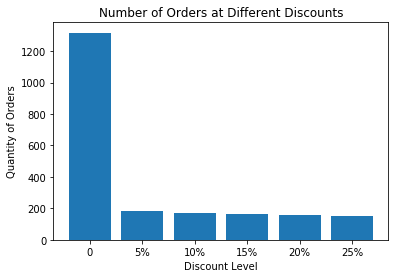

In [21]:
X=['0','5%','10%','15%','20%','25%']
y=list(OrderDetail["Discount"].value_counts()[:])
y=y[:6]
plt.bar(X,y)
plt.title('Number of Orders at Different Discounts')
plt.ylabel('Quantity of Orders')
plt.xlabel('Discount Level')
plt.show()

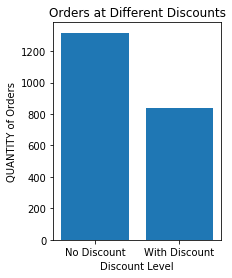

In [22]:
x=['No Discount','With Discount']
y2=[1317,838]
plt.figure(figsize=(3,4))
plt.bar(x,y2)
plt.title('Orders at Different Discounts')
plt.ylabel('QUANTITY of Orders')
plt.xlabel('Discount Level')
plt.show()

The value counts for discount levels between .05 and .25 are significant.  Levels .01, .02, .03, .04, and .06 are not significant because they only account for a few orders.

We will visually compare the average quantity of orders at each discount level.

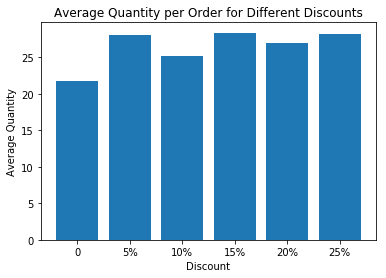

In [23]:
X=['0','5%','10%','15%','20%','25%']
#Y=[OrderDetails['Quantity'][OrderDetails['Discount_bin'==1].mean(),
#                            OrderDetails['Quantity'][OrderDetails['Discount_Bin'==0].mean())
Y=OrderDetail['Quantity'][OrderDetail["Discount"]==0].mean(), OrderDetail['Quantity'][OrderDetail["Discount"]==.05].mean(),OrderDetail['Quantity'][OrderDetail["Discount"]==.10].mean(),OrderDetail['Quantity'][OrderDetail["Discount"]==.15].mean(),OrderDetail['Quantity'][OrderDetail["Discount"]==.20].mean(),OrderDetail['Quantity'][OrderDetail["Discount"]==.25].mean()
plt.bar(X,Y)
plt.title('Average Quantity per Order for Different Discounts')
plt.ylabel('Average Quantity')
plt.xlabel('Discount')
plt.show()
                            

In [24]:
Discounted_Orders=OrderDetail[OrderDetail["Discount"]>.04]
Discounted_Orders=Discounted_Orders[Discounted_Orders['Discount']!=.06]
Discounted_Orders['Discount'].value_counts()

0.05    185
0.10    173
0.20    161
0.15    157
0.25    154
Name: Discount, dtype: int64

In [25]:
Discounted_Orders.head(3)

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
6,10250/51,10250,51,42.4,35,0.15
7,10250/65,10250,65,16.8,15,0.15
8,10251/22,10251,22,16.8,6,0.05


In [26]:
formula="Quantity ~ C(Discount)"
lm=ols(formula, Discounted_Orders).fit()
table=sm.stats.anova_lm(lm, typ=2)  #typ=2 is a TWO-SIDED TEST
table

,sum_sq,df,F,PR(>F)
C(Discount),1159.517551,4.0,0.674103,0.610041
Residual,354768.342690,825.0,NaN,NaN


I'm doing a TWO-SIDED ANOVA TEST, which tests the overall variance as compared to the variance within each category.  A pvalue above our alpha (.05) indicates that all the categories (of discounts) are statistically similiar.

The p-value (PR>F) of our categorical "Discount" variable is .61.  Since this value is >.05, we FAIL TO REJECT the null hypothesis.  This suggests that the average quantity per order is not statistically significant at different discount levels.

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

QUESTION 2:  WHICH PRODUCTS OF CATEGORIES SELL BETTER WITH A DISCOUNT? 

    -NULL HYPOTHESIS:  All products sell the same with a discount.

    -ALTERNATIVE HYPOTHESIS:  Products categories sell differently when offered at a discount.
    
    -TWO-SIDED TEST and ALPHA = .05

To test our hythosis, we will need data from more than one table, so we'll need to join tables.  First, the 'Product' table will be joined to the 'OrderDetail' as 'Prod_Ord_Detail'; and then merge with the 'Categories' table.

In [27]:
Product.head(3)

,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,1,Chai,1,1,10 boxes x 20 bags,18.0,39,0,10,0
1,2,Chang,1,1,24 - 12 oz bottles,19.0,17,40,25,0
2,3,Aniseed Syrup,1,2,12 - 550 ml bottles,10.0,13,70,25,0


In [28]:
OrderDetail.head(3)

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0


In [29]:
Prod_Ord_Detail=pd.merge(Product, OrderDetail, left_on='Id',right_on='ProductId',how='left')
Prod_Ord_Detail.head(3)

,Id_x,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice_x,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued,Id_y,OrderId,ProductId,UnitPrice_y,Quantity,Discount
0,1,Chai,1,1,10 boxes x 20 bags,18.0,39,0,10,0,10285/1,10285,1,14.4,45,0.2
1,1,Chai,1,1,10 boxes x 20 bags,18.0,39,0,10,0,10294/1,10294,1,14.4,18,0.0
2,1,Chai,1,1,10 boxes x 20 bags,18.0,39,0,10,0,10317/1,10317,1,14.4,20,0.0


In [30]:
Category.head(3)

,Id,CategoryName,Description
0,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"
1,2,Condiments,"Sweet and savory sauces, relishes, spreads, an..."
2,3,Confections,"Desserts, candies, and sweet breads"


In [31]:
Prod_OrderDetail_Cat=pd.merge(Prod_Ord_Detail,Category,left_on='CategoryId',right_on='Id',how='left')
Prod_OrderDetail_Cat.head(3)

,Id_x,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice_x,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued,Id_y,OrderId,ProductId,UnitPrice_y,Quantity,Discount,Id,CategoryName,Description
0,1,Chai,1,1,10 boxes x 20 bags,18.0,39,0,10,0,10285/1,10285,1,14.4,45,0.2,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"
1,1,Chai,1,1,10 boxes x 20 bags,18.0,39,0,10,0,10294/1,10294,1,14.4,18,0.0,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"
2,1,Chai,1,1,10 boxes x 20 bags,18.0,39,0,10,0,10317/1,10317,1,14.4,20,0.0,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"


I'm going to remove the irrelevant columns.  And I'm going to convert the 'Discount' column into a categorical column with '1' for discount and '0' for no discount.

In [32]:
Prod_OrderDetail_Cat2=Prod_OrderDetail_Cat[['ProductName','UnitPrice_x','UnitPrice_y','Quantity','Discount',
                                            'CategoryName','Description']]
Prod_OrderDetail_Cat2['Discount']=Prod_OrderDetail_Cat2['Discount'].apply(lambda x: 1 if x>0 else 0)
Prod_OrderDetail_Cat2.head(3)

/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,ProductName,UnitPrice_x,UnitPrice_y,Quantity,Discount,CategoryName,Description
0,Chai,18.0,14.4,45,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"
1,Chai,18.0,14.4,18,0,Beverages,"Soft drinks, coffees, teas, beers, and ales"
2,Chai,18.0,14.4,20,0,Beverages,"Soft drinks, coffees, teas, beers, and ales"


Since we want to test the 'Discount' and 'Category' on 'Quantity' for 'CategoryName', we will use ANOVA to test the hypothesis.  The ANOVA Test is comparing the variance of the "CategoryName" & "Discount" to the overall variance.

In [33]:
formula='Quantity~C(CategoryName)*C(Discount)'
lm_Prod=ols(formula,Prod_OrderDetail_Cat2).fit()
table=sm.stats.anova_lm(lm_Prod,typ=2)  #TWO-SIDED TEST
table

,sum_sq,df,F,PR(>F)
C(CategoryName),1118.470015,7.0,0.449689,8.708672e-01
C(Discount),14729.606130,1.0,41.454988,1.484744e-10
C(CategoryName):C(Discount),3357.463105,7.0,1.349892,2.226259e-01
Residual,760020.189876,2139.0,NaN,NaN


The pvalue > .05 for C(CategoryName):C(Discount), so this does NOT indicates that there is a difference in the Categories when combined with Discount.  So, next we'll look at the lm.summary to look at each category individually.

In [34]:
lm_Prod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Quantity   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     3.636
Date:                Mon, 25 Mar 2019   Prob (F-statistic):           2.61e-06
Time:                        08:27:01   Log-Likelihood:                -9377.9
No. Observations:                2155   AIC:                         1.879e+04
Df Residuals:                    2139   BIC:                         1.888e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
======================================================================================================================
                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
Intercept                                             20.7967      1.202     17.304      0.000      18.440      23.154
C(CategoryName)[T.Condiments]                          0.5239      2.039      0.257      0.797      -3.474       4.522
C(CategoryName)[T.Confections]                         2.2933      1.795      1.278      0.201      -1.226       5.813
C(CategoryName)[T.Dairy Products]                      1.3684      1.741      0.786      0.432      -2.046       4.782
C(CategoryName)[T.Grains/Cereals]                      1.9476      2.029      0.960      0.337      -2.031       5.926
C(CategoryName)[T.Meat/Poultry]                       -0.0751      2.260     -0.033      0.973      -4.507       4.357
C(CategoryName)[T.Produce]                             0.1593      2.313      0.069      0.945      -4.376       4.695
C(CategoryName)[T.Seafood]                             0.5622      1.807      0.311      0.756      -2.982       4.107
C(Discount)[T.1]                                       7.1526      1.922      3.722      0.000       3.384      10.921
C(CategoryName)[T.Condiments]:C(Discount)[T.1]         0.9974      3.254      0.307      0.759      -5.383       7.378
C(CategoryName)[T.Confections]:C(Discount)[T.1]       -5.7053      2.850     -2.002      0.045     -11.294      -0.117
C(CategoryName)[T.Dairy Products]:C(Discount)[T.1]     0.1470      2.790      0.053      0.958      -5.324       5.618
C(CategoryName)[T.Grains/Cereals]:C(Discount)[T.1]    -5.5002      3.465     -1.587      0.113     -12.295       1.295
C(CategoryName)[T.Meat/Poultry]:C(Discount)[T.1]       0.9284      3.469      0.268      0.789      -5.874       7.731
C(CategoryName)[T.Produce]:C(Discount)[T.1]           -4.0420      3.936     -1.027      0.305     -11.761       3.677
C(CategoryName)[T.Seafood]:C(Discount)[T.1]           -2.4671      2.854     -0.864      0.387      -8.065       3.130
==============================================================================
Omnibus:                      775.886   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2992.716
Skew:                           1.746   Prob(JB):                         0.00
Kurtosis:                       7.597   Cond. No.                         18.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Form the above table, we can see that the interaction of 'CategoryName' and 'Discount' has a p-value < .05.  So, we REJECT THE NULL HYPOTHESIS.  There is a stastical difference in quantity of product ordered by atleast one of the Category when a discount is applied.  THEREFORE, the Different Categories react differently to being sold at a discount.

We can also view a plot of our variable to show the relationship of CategoryName & Discount

([<matplotlib.axis.XTick at 0x1c19a274e0>,
 <a list of 2 Text xticklabel objects>)

<Figure size 720x576 with 0 Axes>

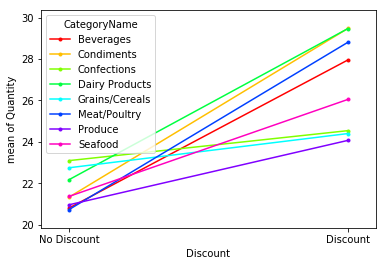

In [35]:
plt.figure(figsize=(10,8))
fig = interaction_plot(Prod_OrderDetail_Cat2['Discount'],Prod_OrderDetail_Cat2['CategoryName'], 
                       Prod_OrderDetail_Cat2['Quantity'])
plt.xticks(np.arange(0, 1.2),['No Discount','Discount'])

In the above visualization, lines that have similar slopes have similar interactions between "CategoryName" & "Discount"    

'Confections' and 'Grain/Cerels' have visually DIFFERENT slopes than the other 6 categories.  Visually, these 2 categories are SIGNIFICANT.  And for Confections, this is proven by the ANOVA test.

CONCLUSION:  Our findings signify that there is sufficent evident that Confections (and possibly 'Grains/Cereals) do NOT benefit from discounting.   Conversely, Meat/Poultry, Condiments, and Beverages DO benefit from selling at a discount. 

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

QUESTION 3:  IS THERE AN OPTIMAL DISCOUNT LEVEL BASED ON THE PRICE OF THE PRODUCT?  

For this question, we will determine is there is an interaction between the "Discount" and the "UnitPrice".  For this analysis, we can determine if there is a higher quantity ordered based on "UnitPrice" and "Discounts".  I'll categorize "Discounts" into 2 categories, since our previous tests showed no difference in quantity ordered at the different discount levels.

NULL HYPOTHESIS:  There is no interaction between "Discount" and "UnitPrice".  The "Quantity" ordered is the same at different "UnitPrices" when the "Discount" is the same.

ALTERNATIVE HYPOTHESIS:  There is an interaction at between "Discount" and "UnitPrice".

ONE-SIDED TEST & ALPHA = .05

In [36]:
Prod_OrderDetail_Cat2.head(10)

,ProductName,UnitPrice_x,UnitPrice_y,Quantity,Discount,CategoryName,Description
0,Chai,18.0,14.4,45,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"
1,Chai,18.0,14.4,18,0,Beverages,"Soft drinks, coffees, teas, beers, and ales"
2,Chai,18.0,14.4,20,0,Beverages,"Soft drinks, coffees, teas, beers, and ales"
3,Chai,18.0,14.4,15,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"
4,Chai,18.0,14.4,12,0,Beverages,"Soft drinks, coffees, teas, beers, and ales"
5,Chai,18.0,14.4,15,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"
6,Chai,18.0,14.4,10,0,Beverages,"Soft drinks, coffees, teas, beers, and ales"
7,Chai,18.0,14.4,24,0,Beverages,"Soft drinks, coffees, teas, beers, and ales"
8,Chai,18.0,14.4,15,0,Beverages,"Soft drinks, coffees, teas, beers, and ales"
9,Chai,18.0,18.0,40,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"


In [37]:
Prod_OrderDetail_Cat3=Prod_OrderDetail_Cat2[['UnitPrice_y','Quantity','Discount']]

In [38]:
formula = 'Quantity ~ C(Discount) * UnitPrice_y'
lm_OrdDet = ols(formula, Prod_OrderDetail_Cat3).fit()
lm_OrdDet.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Quantity   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     14.03
Date:                Mon, 25 Mar 2019   Prob (F-statistic):           4.63e-09
Time:                        08:27:11   Log-Likelihood:                -9384.2
No. Observations:                2155   AIC:                         1.878e+04
Df Residuals:                    2151   BIC:                         1.880e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       21.6653      0.692     31.294      0.000      20.308      23.023
C(Discount)[T.1]                 5.2196      1.109      4.708      0.000       3.045       7.394
UnitPrice_y                      0.0019      0.017      0.109      0.913      -0.032       0.036
C(Discount)[T.1]:UnitPrice_y     0.0066      0.028      0.238      0.812      -0.048       0.061
==============================================================================
Omnibus:                      781.901   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3019.427
Skew:                           1.761   Prob(JB):                         0.00
Kurtosis:                       7.606   Cond. No.                         129.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

CONCLUSION:  pvalue > .05, so WE FAIL TO REJECT that combining "UnitPrice" and "Discount" will produce a statistical difference in the quantity of products ordered.

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

QUESTION 4:  IS THERE A METHOD TO IDENTIFY THE TOP PERFORMING SALESPEOPLE AND COMPENSATE THEM ACCORDINGLY? 

NULL HYPTOHESES:  All Salespeople produce the same amount of sales revenues.

ALTERNATIVE HYPOTHESES:  Top Performing Salespeople generate higher sales revenues.

The alpha level, the probability of rejecting the null hypothesis when it is true, is set at 0.05.

First, I'll identify the names of the salespeople and the number & names of their territories. 

In [39]:
len(Territory), len(EmployeeTerritory), len(Region), len (Employee)

(53, 49, 4, 9)

The ERD tables show that there are 53 Territories, 49 Employee Territories, 4 Regions, and 9 Employees.  SPOILER ALERT......the following note was added after completing most of my analysis..... EDA on these tables and the working with the Customer Table, it's found that the 'Territory', 'EmployeeTerritory', and 'Region' tables do not provide the most useful information.  I found that it was best to separate Customers and Orders using the "ShipRegion" and "ShipCountry" columns in the 'Customer' table.

In [40]:
pd.read_sql_query('''SELECT LastName, FirstName, Title FROM Employee''', engine)

2019-03-25 08:27:18,613 INFO sqlalchemy.engine.base.Engine SELECT LastName, FirstName, Title FROM Employee
2019-03-25 08:27:18,615 INFO sqlalchemy.engine.base.Engine ()


,LastName,FirstName,Title
0,Davolio,Nancy,Sales Representative
1,Fuller,Andrew,"Vice President, Sales"
2,Leverling,Janet,Sales Representative
3,Peacock,Margaret,Sales Representative
4,Buchanan,Steven,Sales Manager
5,Suyama,Michael,Sales Representative
6,King,Robert,Sales Representative
7,Callahan,Laura,Inside Sales Coordinator
8,Dodsworth,Anne,Sales Representative


Of the 9 Employees, 6 have the title of Sales Representative.  Let's determine the annual sales of all of the 9 Employees that are 'assigned' to the orders.

First, let's see how each customer is assigned a sales rep to determine if the Sales Manager or Inside Sales Coordinator is assign to any customers.

In [41]:
Customer.head(1)

,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,Western Europe,12209,Germany,030-0074321,030-0076545


*********For the purposes of this project, I found it simplier to joining multiple tables using Pandas instead of a single SQL Query, so I switched to using Pandas to query multiple tables.  (I'll write a blog post that explore this topic further)************

In [42]:
print("There are {} employees, {} Customers, {} Orders, and 2155 Lines of 'Order Details'.".format(len(Employee),len(Customer),\
len(Order), len(OrderDetail)))

There are 9 employees, 91 Customers, 830 Orders, and 2155 Lines of 'Order Details'.


In the process of merging 4 tables, I've had to:  1.  decide to use SQL v. Pandas Query, 2. Convert one of foreign keys to an object (or int64) so that I could merge OrderDetail with Order.

In [43]:
OrderDetail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 6 columns):
Id           2155 non-null object
OrderId      2155 non-null int64
ProductId    2155 non-null int64
UnitPrice    2155 non-null float64
Quantity     2155 non-null int64
Discount     2155 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 101.1+ KB


In [44]:
Order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830 entries, 0 to 829
Data columns (total 14 columns):
Id                830 non-null int64
CustomerId        830 non-null object
EmployeeId        830 non-null int64
OrderDate         830 non-null object
RequiredDate      830 non-null object
ShippedDate       809 non-null object
ShipVia           830 non-null int64
Freight           830 non-null float64
ShipName          830 non-null object
ShipAddress       830 non-null object
ShipCity          830 non-null object
ShipRegion        830 non-null object
ShipPostalCode    811 non-null object
ShipCountry       830 non-null object
dtypes: float64(1), int64(3), object(10)
memory usage: 90.9+ KB


In [45]:
Customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91 entries, 0 to 90
Data columns (total 11 columns):
Id              91 non-null object
CompanyName     91 non-null object
ContactName     91 non-null object
ContactTitle    91 non-null object
Address         91 non-null object
City            91 non-null object
Region          91 non-null object
PostalCode      90 non-null object
Country         91 non-null object
Phone           91 non-null object
Fax             69 non-null object
dtypes: object(11)
memory usage: 7.9+ KB


In [46]:
Employee.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 18 columns):
Id                 9 non-null int64
LastName           9 non-null object
FirstName          9 non-null object
Title              9 non-null object
TitleOfCourtesy    9 non-null object
BirthDate          9 non-null object
HireDate           9 non-null object
Address            9 non-null object
City               9 non-null object
Region             9 non-null object
PostalCode         9 non-null object
Country            9 non-null object
HomePhone          9 non-null object
Extension          9 non-null object
Photo              0 non-null object
Notes              9 non-null object
ReportsTo          8 non-null float64
PhotoPath          9 non-null object
dtypes: float64(1), int64(1), object(16)
memory usage: 1.3+ KB


In [47]:
Salespeople_Terr=pd.read_sql_query('''SELECT e.LastName, e.FirstName, COUNT(t.Id) num_territories FROM [Employee] 
    e JOIN EmployeeTerritory t ON (e.Id=t.EmployeeId) GROUP BY t.EmployeeId ORDER BY COUNT(t.Id) DESC''',engine)
print(Salespeople_Terr)

2019-03-25 08:27:33,312 INFO sqlalchemy.engine.base.Engine SELECT e.LastName, e.FirstName, COUNT(t.Id) num_territories FROM [Employee] 
    e JOIN EmployeeTerritory t ON (e.Id=t.EmployeeId) GROUP BY t.EmployeeId ORDER BY COUNT(t.Id) DESC
2019-03-25 08:27:33,313 INFO sqlalchemy.engine.base.Engine ()
    LastName FirstName  num_territories
0       King    Robert               10
1     Fuller    Andrew                7
2   Buchanan    Steven                7
3  Dodsworth      Anne                7
4     Suyama   Michael                5
5  Leverling     Janet                4
6   Callahan     Laura                4
7    Peacock  Margaret                3
8    Davolio     Nancy                2


In [48]:
Employee.head(3)

,Id,LastName,FirstName,Title,TitleOfCourtesy,BirthDate,HireDate,Address,City,Region,PostalCode,Country,HomePhone,Extension,Photo,Notes,ReportsTo,PhotoPath
0,1,Davolio,Nancy,Sales Representative,Ms.,1980-12-08,2024-05-01,507 - 20th Ave. E. Apt. 2A,Seattle,North America,98122,USA,(206) 555-9857,5467,None,Education includes a BA in psychology from Col...,2.0,http://accweb/emmployees/davolio.bmp
1,2,Fuller,Andrew,"Vice President, Sales",Dr.,1984-02-19,2024-08-14,908 W. Capital Way,Tacoma,North America,98401,USA,(206) 555-9482,3457,None,Andrew received his BTS commercial in 1974 and...,NaN,http://accweb/emmployees/fuller.bmp
2,3,Leverling,Janet,Sales Representative,Ms.,1995-08-30,2024-04-01,722 Moss Bay Blvd.,Kirkland,North America,98033,USA,(206) 555-3412,3355,None,Janet has a BS degree in chemistry from Boston...,2.0,http://accweb/emmployees/leverling.bmp


In [49]:
Order=pd.read_sql_query('''SELECT * FROM [Order] ''',engine)
type(Order)
Order['OrderDate']=pd.to_datetime(Order['OrderDate'])

2019-03-25 08:27:36,770 INFO sqlalchemy.engine.base.Engine SELECT * FROM [Order] 
2019-03-25 08:27:36,771 INFO sqlalchemy.engine.base.Engine ()


In [50]:
Order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830 entries, 0 to 829
Data columns (total 14 columns):
Id                830 non-null int64
CustomerId        830 non-null object
EmployeeId        830 non-null int64
OrderDate         830 non-null datetime64[ns]
RequiredDate      830 non-null object
ShippedDate       809 non-null object
ShipVia           830 non-null int64
Freight           830 non-null float64
ShipName          830 non-null object
ShipAddress       830 non-null object
ShipCity          830 non-null object
ShipRegion        830 non-null object
ShipPostalCode    811 non-null object
ShipCountry       830 non-null object
dtypes: datetime64[ns](1), float64(1), int64(3), object(9)
memory usage: 90.9+ KB


In [51]:
OrderDetail.head(1)

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0


Below I'll merge Employee, Order, Customer, and OrderDetail to see how much each salesperson produces.

In [52]:
Emp_Ord_Cust_OrDet=Employee.merge(Order, left_on='Id',right_on='EmployeeId',how='left').merge(Customer, left_on=
    'CustomerId',right_on='Id', how='left').merge(OrderDetail, left_on='Id_y', right_on='OrderId', how='left')
#Emp_Ord_Cust_OrdDet.columns
Emp_Ord_Cust_OrDet2=Emp_Ord_Cust_OrDet[['Id_x','LastName','FirstName','Title','CustomerId','OrderDate','UnitPrice'
    ,'Quantity','Discount']]
Emp_Ord_Cust_OrDet2.head()

,Id_x,Id_x,LastName,FirstName,Title,CustomerId,OrderDate,UnitPrice,Quantity,Discount
0,1,ERNSH,Davolio,Nancy,Sales Representative,ERNSH,2012-07-17,15.2,50,0.2
1,1,ERNSH,Davolio,Nancy,Sales Representative,ERNSH,2012-07-17,17.0,65,0.2
2,1,ERNSH,Davolio,Nancy,Sales Representative,ERNSH,2012-07-17,25.6,6,0.2
3,1,WARTH,Davolio,Nancy,Sales Representative,WARTH,2012-08-01,15.2,30,0.0
4,1,WARTH,Davolio,Nancy,Sales Representative,WARTH,2012-08-01,36.8,25,0.0


In [53]:
Emp_Ord_Cust_OrDet2['Revenue']=Emp_Ord_Cust_OrDet2['UnitPrice']*Emp_Ord_Cust_OrDet2['Quantity']*(1-Emp_Ord_Cust_OrDet2['Discount'])
Emp_Ord_Cust_OrDet2.head()

/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Id_x,Id_x,LastName,FirstName,Title,CustomerId,OrderDate,UnitPrice,Quantity,Discount,Revenue
0,1,ERNSH,Davolio,Nancy,Sales Representative,ERNSH,2012-07-17,15.2,50,0.2,608.00
1,1,ERNSH,Davolio,Nancy,Sales Representative,ERNSH,2012-07-17,17.0,65,0.2,884.00
2,1,ERNSH,Davolio,Nancy,Sales Representative,ERNSH,2012-07-17,25.6,6,0.2,122.88
3,1,WARTH,Davolio,Nancy,Sales Representative,WARTH,2012-08-01,15.2,30,0.0,456.00
4,1,WARTH,Davolio,Nancy,Sales Representative,WARTH,2012-08-01,36.8,25,0.0,920.00


Northwinds has made sales from JULY 4TH, 2012 to MAY 5TH, 2014.  So, I'll compare the FIRST 10 months (7/4/12-5/6/13) to the LAST 12 months(5/7/13-5/6/14).  It's MOST important the compare the last 12 months, because I'll being analyzing the last 12 months in different areas of the business.

In [54]:
Emp_Ord_Cust_OrDet_First10mos=Emp_Ord_Cust_OrDet2[Emp_Ord_Cust_OrDet2['OrderDate']<=dt.datetime(2013,5,6)]

Emp_Ord_Cust_OrDet_Last12mos=Emp_Ord_Cust_OrDet2[Emp_Ord_Cust_OrDet2['OrderDate']>=dt.datetime(2013,5,7)]
len(Emp_Ord_Cust_OrDet_First10mos), len(Emp_Ord_Cust_OrDet_Last12mos)

(745, 1410)

2013 was the most recent FULL year of sales, so we will analyze these orders.  In 2013, there were 1059 Order Details.  Now, we will see, which employee was assigned to each of these orders.

In [55]:
Emp_Ord_Cust_OrDet_First10mos.Revenue.sum(),Emp_Ord_Cust_OrDet_Last12mos.Revenue.sum()

(408907.8075, 856885.232)

In [56]:
len(Order[Order['OrderDate']<=dt.datetime(2013,5,6)]),len(Order[Order['OrderDate']>=dt.datetime(2013,5,7)])

(281, 549)

Northwinds has been open and taking orders from 7/4/2012 to 5/6/2014.  In the first 10 months (7/4/12-5/6/13), 281 Orders (745 OrderDetails) worth $408,908 ($490,690 annualized); In the last 12 months, 549 Orders (1059 Order Details) worth $856,885.  

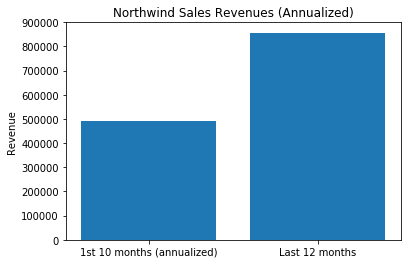

In [57]:
x=[2013,2014]
y=[490690,856885]
plt.bar(x,y,tick_label=('1st 10 months (annualized)','Last 12 months'))
plt.ylabel('Revenue')
plt.title('Northwind Sales Revenues (Annualized)')
plt.show()

In [58]:
Emp_Ord_Cust_OrDet_First10mos.head()

,Id_x,Id_x,LastName,FirstName,Title,CustomerId,OrderDate,UnitPrice,Quantity,Discount,Revenue
0,1,ERNSH,Davolio,Nancy,Sales Representative,ERNSH,2012-07-17,15.2,50,0.2,608.00
1,1,ERNSH,Davolio,Nancy,Sales Representative,ERNSH,2012-07-17,17.0,65,0.2,884.00
2,1,ERNSH,Davolio,Nancy,Sales Representative,ERNSH,2012-07-17,25.6,6,0.2,122.88
3,1,WARTH,Davolio,Nancy,Sales Representative,WARTH,2012-08-01,15.2,30,0.0,456.00
4,1,WARTH,Davolio,Nancy,Sales Representative,WARTH,2012-08-01,36.8,25,0.0,920.00


Here, I'm grouping the sum of Customer Sales Revenues by each salesperson's Last Name.  This is done for the first 10 months and the last 12 months.  Then, a bar plot for each will show any differences between the 2 periods.

In [59]:
Sales_1st10mos_Rep=Emp_Ord_Cust_OrDet_First10mos.groupby(['LastName'])['Revenue'].sum().to_frame('Revenue')
Sales_1st10mos_Rep.reset_index()


,LastName,Revenue
0,Buchanan,20904.3200
1,Callahan,41724.9350
2,Davolio,54417.6400
3,Dodsworth,12931.2950
4,Fuller,42364.4900
5,King,43106.7725
6,Leverling,57269.5650
7,Peacock,105661.0450
8,Suyama,30527.7450


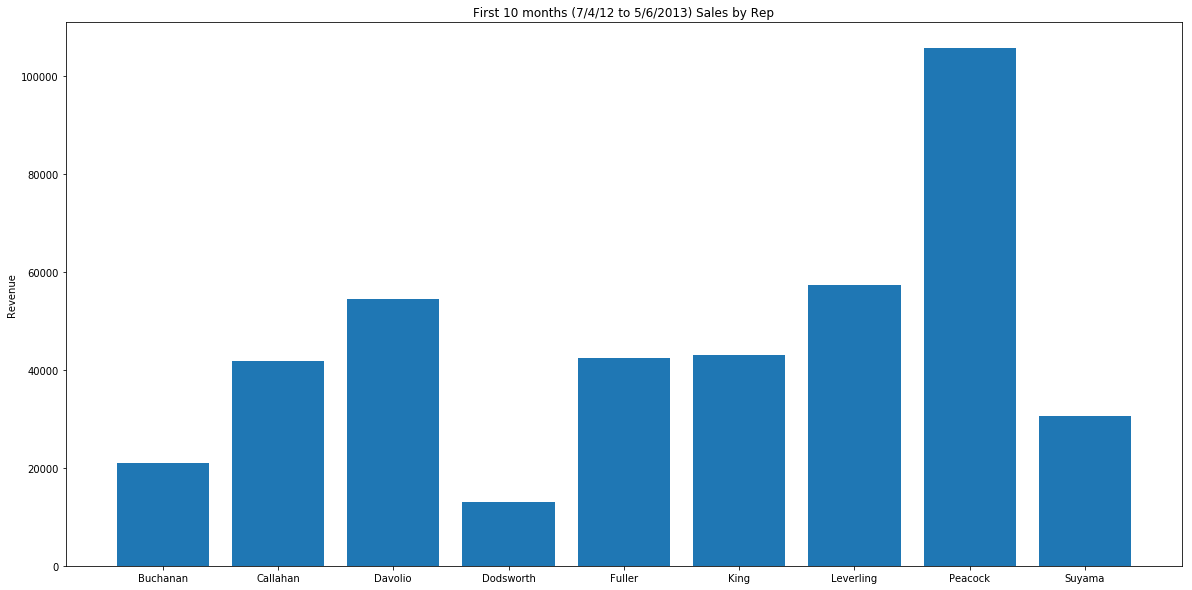

In [60]:
plt.figure(figsize=(20,10))
x=Sales_1st10mos_Rep.index
y=Sales_1st10mos_Rep['Revenue']
plt.bar(x,y,)
plt.ylabel('Revenue')
plt.title('First 10 months (7/4/12 to 5/6/2013) Sales by Rep')
plt.show()

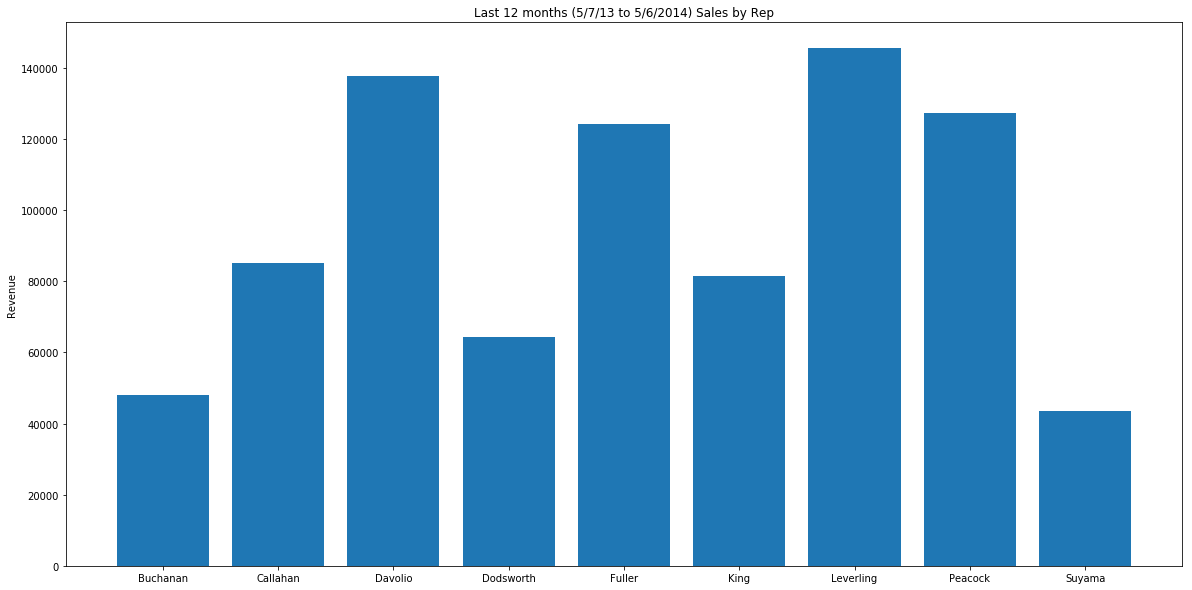

In [61]:
Sales_Last12mos_Rep=Emp_Ord_Cust_OrDet_Last12mos.groupby(['LastName'])['Revenue'].sum().to_frame('Revenue')
plt.figure(figsize=(20,10))
x=Sales_Last12mos_Rep.index
y=Sales_Last12mos_Rep['Revenue']
plt.bar(x,y,)
plt.ylabel('Revenue')
plt.title('Last 12 months (5/7/13 to 5/6/2014) Sales by Rep')
plt.show()

In [62]:
Sales_Last12mos_Rep

,Revenue
LastName,
Buchanan,47887.9625
Callahan,85137.3425
Davolio,137689.9645
Dodsworth,64376.7715
Fuller,124173.2650
King,81461.4625
Leverling,145543.2780
Peacock,127229.8010
Suyama,43385.3845


In [63]:
Sales_Last12mos_Rep.describe()

,Revenue
count,9.000000
mean,95209.470222
std,39319.936623
min,43385.384500
25%,64376.771500
50%,85137.342500
75%,127229.801000
max,145543.278000


The bar histogram and the statistic seem to lend evident to REJECT the Null Hypothesis.  There appears to be difference in the each Salesperson's Revenue and all Salespeople are not the same.

We need to find a metric in which to analyze the performance of the sales reps, other than 'total revenue'.  This could be: 

    -Average Revenue per Order by Salesperson
    -Number of Orders by Salesperson
    -Quantity Sold per Order
    
Once we have an average, then we can see if there's a stastical difference that separates salespeople.

Are the following factors influencial in total sales volumes:  Average Revenue per Order by Salesperson or Number of Orders by Salesperson?


Here, I'll merge Employee, Order, Customer, and Order Detail tables. This will allow me to analyze the average territories, orders, customers, and order details in different ways.

Because the column name, 'Id', is used in every table; I'll have to merge Order, Customer, & OrderDetail tables first and then merge them to the other 3 tables. This is done below.

In [64]:
Ord_Cust_OrdDet=Order.merge(Customer, left_on='CustomerId',right_on='Id',how='left')\
                            .merge(OrderDetail, left_on='Id_x',right_on='OrderId')
Ord_Cust_OrdDet2=Ord_Cust_OrdDet[Ord_Cust_OrdDet['OrderDate']>=dt.datetime(2013,5,7)]
len(Ord_Cust_OrdDet2)

1410

In [65]:
Ord_Cust_OrdDet2.head(1)

,Id_x,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,...,PostalCode,Country,Phone,Fax,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
745,10529,MAISD,5,2013-05-07,2013-06-04,2013-05-09,2,66.69,Maison Dewey,Rue Joseph-Bens 532,...,B-1180,Belgium,(02) 201 24 67,(02) 201 24 68,10529/55,10529,55,24.0,14,0.0


In [66]:
Emp_Ord_Cust_OrdDet=Employee.merge(Ord_Cust_OrdDet2,left_on='Id', right_on='EmployeeId',how='left')
Emp_Ord_Cust_OrdDet.head(1)

,Id_x,LastName,FirstName,Title,TitleOfCourtesy,BirthDate,HireDate,Address_x,City_x,Region_x,...,PostalCode_y,Country_y,Phone,Fax,Id_y,OrderId,ProductId,UnitPrice,Quantity,Discount
0,1,Davolio,Nancy,Sales Representative,Ms.,1980-12-08,2024-05-01,507 - 20th Ave. E. Apt. 2A,Seattle,North America,...,1203,Switzerland,0897-034214,None,10537/31,10537,31,12.5,30,0.0


Now, I'll make a table with the relevant columns:  title, hire date, # of customers, # of orders, OrderDetail lines of orders, average dollar amount of each order FOR THE LAST 12 MONTHS.

In [67]:
Emp_Ord_Cust_OrdDet2=Emp_Ord_Cust_OrdDet[['LastName','Title','HireDate','CustomerId','OrderDate','OrderId',\
    'Id_y','UnitPrice','Quantity','Discount']]
Emp_Ord_Cust_OrdDet2['Revenue']=Emp_Ord_Cust_OrdDet2['UnitPrice']*Emp_Ord_Cust_OrdDet2['Quantity']*(1-\
        Emp_Ord_Cust_OrdDet2['Discount'])
Emp_Ord_Cust_OrdDet2.head()

/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,LastName,Title,HireDate,CustomerId,OrderDate,OrderId,Id_y,Id_y,UnitPrice,Quantity,Discount,Revenue
0,Davolio,Sales Representative,2024-05-01,RICSU,2013-05-14,10537,RICSU,10537/31,12.50,30,0.0,375.0
1,Davolio,Sales Representative,2024-05-01,RICSU,2013-05-14,10537,RICSU,10537/51,53.00,6,0.0,318.0
2,Davolio,Sales Representative,2024-05-01,RICSU,2013-05-14,10537,RICSU,10537/58,13.25,20,0.0,265.0
3,Davolio,Sales Representative,2024-05-01,RICSU,2013-05-14,10537,RICSU,10537/72,34.80,21,0.0,730.8
4,Davolio,Sales Representative,2024-05-01,RICSU,2013-05-14,10537,RICSU,10537/73,15.00,9,0.0,135.0


In [68]:
print('Northwinds had {} unique customers in the last 12 months'.format(len(Emp_Ord_Cust_OrdDet2.CustomerId.unique())))

Northwinds had 88 unique customers in the last 12 months


In [69]:
print('Northwinds Total Revenue in the last 12 months was {}.'.format(int(Emp_Ord_Cust_OrdDet2.Revenue.sum())))

Northwinds Total Revenue in the last 12 months was 856885.


Before I group average Order and Customer Revenue by Salesperson; first I'll do some EDA on the average (Order & Customer Revenue) FOR THE COMPANY.  

First, I'll group "OrderId" and sum the Revenue orders.  Then, we'll get the 5-point statistics on the Customers' orders and plot on a histogram.  It's important to use "OrderId" instead of "OrderDate" because "OrderId" is unique to the order, but the "OrderDate" is not.

In [70]:
Emp_Ord_Cust_OrdDet2__Order_Grp=Emp_Ord_Cust_OrdDet2.groupby(['LastName','Title','HireDate','CustomerId',\
                            'OrderId'])['Revenue'].sum().to_frame().reset_index()
Emp_Ord_Cust_OrdDet2__Order_Grp.describe()

,OrderId,Revenue
count,549.000000,549.000000
mean,10803.000000,1560.810987
std,158.626921,1907.320396
min,10529.000000,12.500000
25%,10666.000000,477.000000
50%,10803.000000,932.050000
75%,10940.000000,1930.400000
max,11077.000000,16387.500000


There were 549 ORDERS placed in the last 12 months.  The average ORDER size was $1560 (Median of $932).  Next, I'll plot on a histogram.

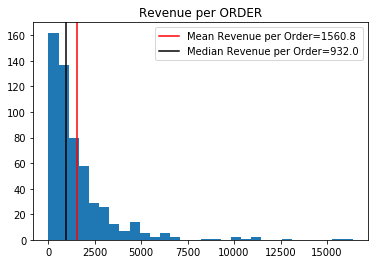

In [71]:
plt.hist(Emp_Ord_Cust_OrdDet2__Order_Grp['Revenue'],bins=30)
plt.axvline(Emp_Ord_Cust_OrdDet2__Order_Grp['Revenue'].mean(),color='red',label='Mean Revenue per Order={}'.\
            format(round(Emp_Ord_Cust_OrdDet2__Order_Grp['Revenue'].mean(),1)))
plt.axvline(Emp_Ord_Cust_OrdDet2__Order_Grp['Revenue'].median(),color='black',label='Median Revenue per Order={}'\
            .format(round(Emp_Ord_Cust_OrdDet2__Order_Grp['Revenue'].median(),1)))
plt.title('Revenue per ORDER')
plt.legend()

Below, I'm using EDA to determine if there are 349 Customers or 88.  There are 349 lines when grouped by LastName and CustomerId but 88 lines when grouped by CustomerId.  

In my first attempt to prove the hypothesis, I assumed that each customer was serviced by one and only one salesperson.  However, after further EDA, it was determined that there are 88 unique customers serviced by multiple salespeople.  So, our analysis will SHIFT TO FOCUS on the orders placed by the Salespeople.

In [72]:
Cust_Grp319=Emp_Ord_Cust_OrdDet2__Order_Grp.groupby(['CustomerId'])['LastName'].unique().to_frame().reset_index()
Cust_Grp319.head()

,CustomerId,LastName
0,ALFKI,"[Davolio, Leverling, Peacock, Suyama]"
1,ANATR,"[Leverling, Peacock]"
2,ANTO,"[Davolio, King, Leverling, Peacock]"
3,AROUT,"[Davolio, Dodsworth, Leverling, Peacock]"
4,BERGS,"[Buchanan, Callahan, Davolio, Dodsworth, Lever..."


Since there are multiple salespeople assigned to each of the 88 customers, "Average Order per Customer" cannot be used to differentiate salespeople.  "Average Revenue per Order" will be a better measure of performance.

Next, I'll group by Salesperson to calculate the average orders per customer for each salesperson.

First, let's calculate the total orders for each salesperson in the last 12 months.

In [73]:
Emp_Ord_Cust_OrdDet2__TOTORDERCount_GrpbyRep=Emp_Ord_Cust_OrdDet2.groupby(['LastName','Title',\
    'CustomerId','OrderId'])['Revenue'].sum().to_frame('Revenue').reset_index()
Emp_Ord_Cust_OrdDet2__TOTORDERCount_GrpbyRep2=Emp_Ord_Cust_OrdDet2__TOTORDERCount_GrpbyRep.groupby(['LastName'])\
    ['OrderId'].size().to_frame('ORDERS_by_Rep').reset_index()
Emp_Ord_Cust_OrdDet2__TOTORDERCount_GrpbyRep2

,LastName,ORDERS_by_Rep
0,Buchanan,28
1,Callahan,64
2,Davolio,84
3,Dodsworth,34
4,Fuller,68
5,King,47
6,Leverling,85
7,Peacock,98
8,Suyama,41


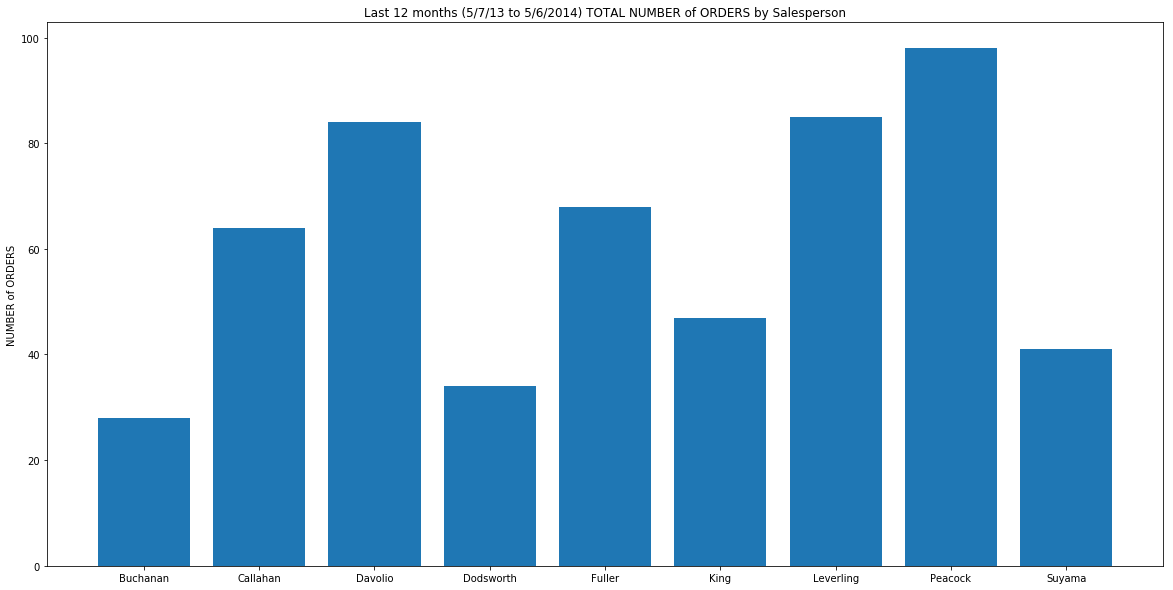

In [74]:
plt.figure(figsize=(20,10))
x=Emp_Ord_Cust_OrdDet2__TOTORDERCount_GrpbyRep2['LastName']
y=Emp_Ord_Cust_OrdDet2__TOTORDERCount_GrpbyRep2['ORDERS_by_Rep']
plt.bar(x,y,)
plt.ylabel('NUMBER of ORDERS')
plt.title('Last 12 months (5/7/13 to 5/6/2014) TOTAL NUMBER of ORDERS by Salesperson')
plt.show()

First, I'll group the sales for each order.

In [75]:
Emp_Ord_Cust_OrdDet2__Order_GrpbyRep=Emp_Ord_Cust_OrdDet2.groupby(['LastName','Title','HireDate',\
                            'CustomerId','OrderId'])['Revenue'].sum().to_frame('Revenue_per_Order').reset_index()
Emp_Ord_Cust_OrdDet2__Order_GrpbyRep.head()

,LastName,Title,HireDate,CustomerId,OrderId,Revenue_per_Order
0,Buchanan,Sales Manager,2025-10-17,BERGS,10654,601.8300
1,Buchanan,Sales Manager,2025-10-17,BERGS,10866,1096.2000
2,Buchanan,Sales Manager,2025-10-17,BONAP,10730,484.2625
3,Buchanan,Sales Manager,2025-10-17,FAMIA,10650,1779.2000
4,Buchanan,Sales Manager,2025-10-17,FRANK,10675,1423.0000


In [76]:
Emp_Ord_Cust_OrdDet2__Order_GrpbyRep2=Emp_Ord_Cust_OrdDet2__Order_GrpbyRep.groupby(['LastName','Title','HireDate'\
    ])['Revenue_per_Order'].mean().to_frame('Avg_Rev_per_Order').reset_index()
Emp_Ord_Cust_OrdDet2__Order_GrpbyRep2

,LastName,Title,HireDate,Avg_Rev_per_Order
0,Buchanan,Sales Manager,2025-10-17,1710.284375
1,Callahan,Inside Sales Coordinator,2026-03-05,1330.270977
2,Davolio,Sales Representative,2024-05-01,1639.166244
3,Dodsworth,Sales Representative,2026-11-15,1893.434456
4,Fuller,"Vice President, Sales",2024-08-14,1826.077426
5,King,Sales Representative,2026-01-02,1733.222606
6,Leverling,Sales Representative,2024-04-01,1712.273859
7,Peacock,Sales Representative,2025-05-03,1298.263276
8,Suyama,Sales Representative,2025-10-17,1058.180110


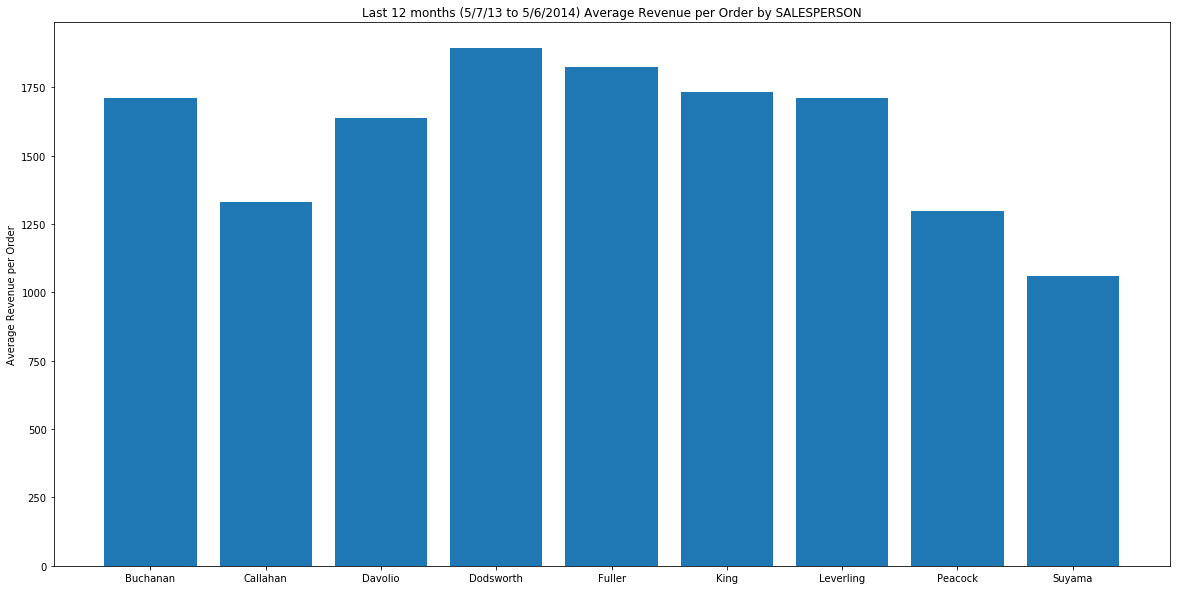

In [77]:
plt.figure(figsize=(20,10))
x=Emp_Ord_Cust_OrdDet2__Order_GrpbyRep2['LastName']
y=Emp_Ord_Cust_OrdDet2__Order_GrpbyRep2['Avg_Rev_per_Order']
plt.bar(x,y,)
plt.ylabel('Average Revenue per Order')
plt.title('Last 12 months (5/7/13 to 5/6/2014) Average Revenue per Order by SALESPERSON')
plt.show()

The graphs show:

    -Leverling is the Salesperson with the highest total revenue, followed by Davolio.  Suyama had the lowest total Revenue.

    -Peacock has the highest Total Number of Customers, followed by Davolio.  Buchanan has the smallest number of Customers.

    -Leverling has the highest average revenue per customer, followed by King.  Suyama has the lowest.

    -Callahan has the highest average number of orders per customer, followed closely by Leverling and Peacock.  Suyama has the lowest.

    -Peacock has the highest number of total number of orders, followed by Leverling and Davolio.  Buchanan has the lowest.

    -Dodsworth has the highest average revenue per order, followed by Fuller.   Suyama has the lowest.

The data and graphs for Total Revenue, Total Number of Customers, Total Number of Orders lend support to the alternate hypothesis that there are significant differences in revenue between salespeople. This was further investigated through the use of statistical hypothesis testing.

###################################  Finally, we are ready to run a t-statisic on Salespeople to see which predictors influenced Total Revenue by Saleperson.  I first began to look at Hire Date, Number of Territories, Average Order Size by Customer by Salesperson, and Average Revenue by Customer by Salesperson.  With further EDA, I found that these predictors were faulty for the following reasons:

    -Hire Date show values that are in the future and cannot be used.
    -Region and Terriory useful information is found within the "Customer" table not in the "Region", "Territory", nor "EmployeeTerritory" tables.  When I looked at the locations of the customers and salesperson assigned to 
    each order, I discovered that all salespeople were not limited by geographical boundaries when selling to 
    customers.  Therefore, "Number of Territories" nor "Average Revenue by Customer by Salesperson" were not good predictors.


Therefore, Average Revenues per Order per Salesperson and Number Orders per Salesperson will be tested. !!!!!!!!!!!!!!!!!!

The first thing I'll do is concatonate the different database columns to put them in one pandas database, so that I can run the t-statistic.

In [78]:
SalesRep_Revenue=Sales_Last12mos_Rep['Revenue'].to_frame().reset_index()
SalesRep_Revenue

,LastName,Revenue
0,Buchanan,47887.9625
1,Callahan,85137.3425
2,Davolio,137689.9645
3,Dodsworth,64376.7715
4,Fuller,124173.2650
5,King,81461.4625
6,Leverling,145543.2780
7,Peacock,127229.8010
8,Suyama,43385.3845


In [79]:
Emp_Ord_Cust_OrdDet2__Order_GrpbyRep2.head(3)

,LastName,Title,HireDate,Avg_Rev_per_Order
0,Buchanan,Sales Manager,2025-10-17,1710.284375
1,Callahan,Inside Sales Coordinator,2026-03-05,1330.270977
2,Davolio,Sales Representative,2024-05-01,1639.166244


In [80]:
Emp_Ord_Cust_OrdDet2__TOTORDERCount_GrpbyRep2.head(3)

,LastName,ORDERS_by_Rep
0,Buchanan,28
1,Callahan,64
2,Davolio,84


In [81]:
SalesRep_Revenue.head(1)

,LastName,Revenue
0,Buchanan,47887.9625


In [82]:
Emp_Ord_Cust_OrdDet2__Order_GrpbyRep2.head(1)

,LastName,Title,HireDate,Avg_Rev_per_Order
0,Buchanan,Sales Manager,2025-10-17,1710.284375


In [83]:
Emp_Ord_Cust_OrdDet2__TOTORDERCount_GrpbyRep2.head(1)

,LastName,ORDERS_by_Rep
0,Buchanan,28


In [86]:
Emp_Ord_Cust_OrDet3=Emp_Ord_Cust_OrDet[['LastName','FirstName','Title','City_x','Region_x','CustomerId','OrderDate',\
    'ShipCity', 'ShipRegion','ShipCountry','OrderId', 'UnitPrice', 'Quantity','Discount']]
Emp_Ord_Cust_OrDet4=Emp_Ord_Cust_OrDet3[Emp_Ord_Cust_OrDet3['OrderDate']>=dt.datetime(2013,5,6)]
Emp_Ord_Cust_OrDet4.head()
print('Northwinds sells into {} regions, this table show the number of countries serviced by each salesperson'.format(len(Emp_Ord_Cust_OrDet4.ShipRegion.unique())))
Region_Grp=Emp_Ord_Cust_OrDet4.groupby(['LastName','City_x','Region_x','ShipRegion'])['ShipRegion'].size().to_frame\
    ('Territory_Region').reset_index()
Region_Grp2=Region_Grp.groupby(['LastName','City_x','Region_x'])['Territory_Region'].size().to_frame\
    ('Territory_Regions').reset_index()
Region_Grp2

Northwinds sells into 9 regions, this table show the number of countries serviced by each salesperson


,LastName,City_x,Region_x,Territory_Regions
0,Buchanan,London,British Isles,7
1,Callahan,Seattle,North America,7
2,Davolio,Seattle,North America,9
3,Dodsworth,London,British Isles,7
4,Fuller,Tacoma,North America,8
5,King,London,British Isles,8
6,Leverling,Kirkland,North America,8
7,Peacock,Redmond,North America,9
8,Suyama,London,British Isles,8


In [93]:
print('Northwinds sells into {} countries, this table show the number of countries serviced by each salesperson'.format(len(Emp_Ord_Cust_OrDet4.ShipCountry.unique())))
Country_Grp=Emp_Ord_Cust_OrDet4.groupby(['LastName','City_x','ShipCountry'])['ShipCountry'].size().to_frame\
    ('Territory_Country').reset_index()
Country_Grp2=Country_Grp.groupby(['LastName','City_x'])['ShipCountry'].size().to_frame\
    ('Territory_Countries').reset_index()
Country_Grp2

Northwinds sells into 21 countries, this table show the number of countries serviced by each salesperson


,LastName,City_x,Territory_Countries
0,Buchanan,London,11
1,Callahan,Seattle,16
2,Davolio,Seattle,21
3,Dodsworth,London,16
4,Fuller,Tacoma,18
5,King,London,19
6,Leverling,Kirkland,18
7,Peacock,Redmond,19
8,Suyama,London,15


In [94]:
frames=[Emp_Ord_Cust_OrdDet2__Order_GrpbyRep2,
       Emp_Ord_Cust_OrdDet2__TOTORDERCount_GrpbyRep2,Region_Grp2,Country_Grp2,SalesRep_Revenue,]

In [102]:
result = pd.concat(frames,axis=1)
result2 = result.loc[:,~result.columns.duplicated()].drop(['HireDate','City_x','Region_x','City_x'],axis=1)
result3=result2
result3['Avg_Rev_per_Order']=result3['Avg_Rev_per_Order'].apply(lambda x: '$' + str(int(x)))
result3['Revenue']=result3['Revenue'].apply(lambda x: '$' + str(int(x)))
result3=result3.set_index('LastName')
result3

,Title,Avg_Rev_per_Order,ORDERS_by_Rep,Territory_Regions,Territory_Countries,Revenue
LastName,,,,,,
Buchanan,Sales Manager,$1710,28,7,11,$47887
Callahan,Inside Sales Coordinator,$1330,64,7,16,$85137
Davolio,Sales Representative,$1639,84,9,21,$137689
Dodsworth,Sales Representative,$1893,34,7,16,$64376
Fuller,"Vice President, Sales",$1826,68,8,18,$124173
King,Sales Representative,$1733,47,8,19,$81461
Leverling,Sales Representative,$1712,85,8,18,$145543
Peacock,Sales Representative,$1298,98,9,19,$127229
Suyama,Sales Representative,$1058,41,8,15,$43385


Finally, I'll run an Ordinary Least Square model (OLS) on Salespeople with the following predictors:  Average Revenues per Order and Number of Orders by Salesperson to see which predictor has the most influence on Revenue.  Then, I'll dig deeper into that predictor to see if there's a difference in Sales Rep Performance.

In [104]:
formula = 'Revenue ~ ORDERS_by_Rep + Avg_Rev_per_Order' 
lm_rev = ols(formula, result).fit()
table = sm.stats.anova_lm(lm_rev, typ=2)
print(table)

                         sum_sq   df           F    PR(>F)
ORDERS_by_Rep      1.153077e+10  1.0  252.036575  0.000004
Avg_Rev_per_Order  1.713278e+09  1.0   37.448396  0.000869
Residual           2.745023e+08  6.0         NaN       NaN


It appears that Avg_Revenue_per_Order (pvalue < .05) and TOT_Num_ORDERS_by_Rep (pvalue < .05) are influential in PREDICTING THE REVENUE of each Salesperson.  Orders by Rep is the most influencial.  

However, this DOES NOT prove or disprove our null hypothesis.  Our null hypothesis is to see if there's a difference in salesperson revenue performance.  

Let's dig deeper and run an ANOVA test to compare Avg_Revenue_per_Order and Orders by Rep to see if there's a statistical difference in Salesperson Performance.  This is a two-tailed test, therefore alpha = .025.

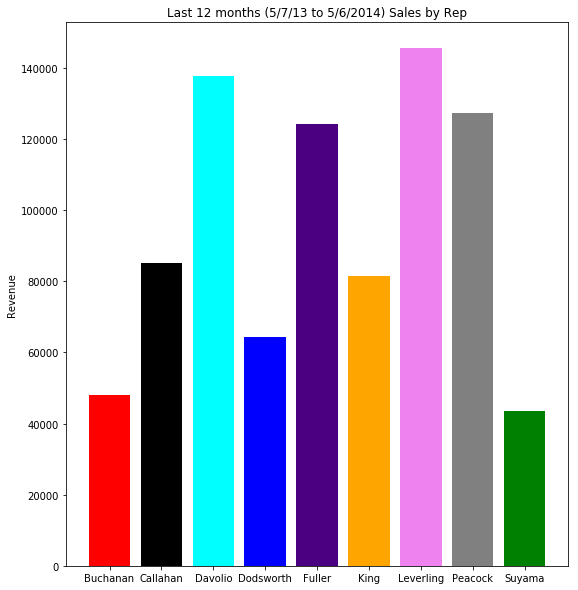

In [105]:
Sales_Last12mos_Rep=Emp_Ord_Cust_OrDet_Last12mos.groupby(['LastName'])['Revenue'].sum().to_frame('Revenue')
plt.figure(figsize=(9,10))
x=Sales_Last12mos_Rep.index
y=Sales_Last12mos_Rep['Revenue']
plt.bar(x,y,color=['red','black','cyan','blue','indigo','orange','violet','grey','green'])
plt.ylabel('Revenue')
plt.title('Last 12 months (5/7/13 to 5/6/2014) Sales by Rep')
plt.show()

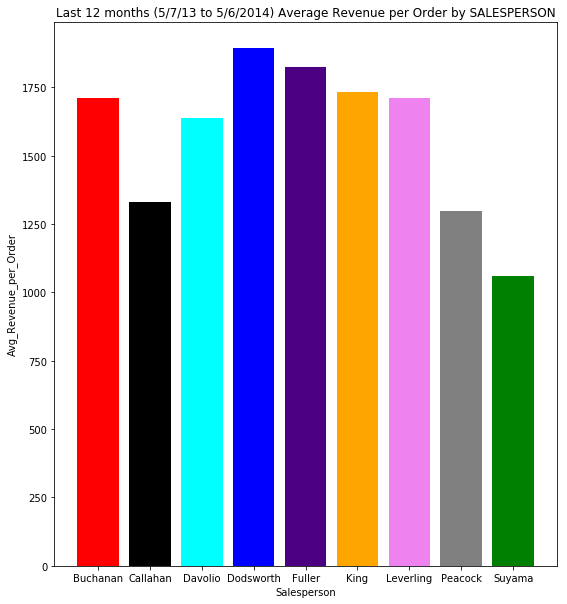

In [108]:
plt.figure(figsize=(9,10))
x=Emp_Ord_Cust_OrdDet2__Order_GrpbyRep2['LastName']
y=Emp_Ord_Cust_OrdDet2__Order_GrpbyRep2['Avg_Rev_per_Order']
plt.bar(x,y,color=['red','black','cyan','blue','indigo','orange','violet','grey','green'])
plt.xlabel('Salesperson')
plt.ylabel('Avg_Revenue_per_Order')
plt.title('Last 12 months (5/7/13 to 5/6/2014) Average Revenue per Order by SALESPERSON')
plt.show()

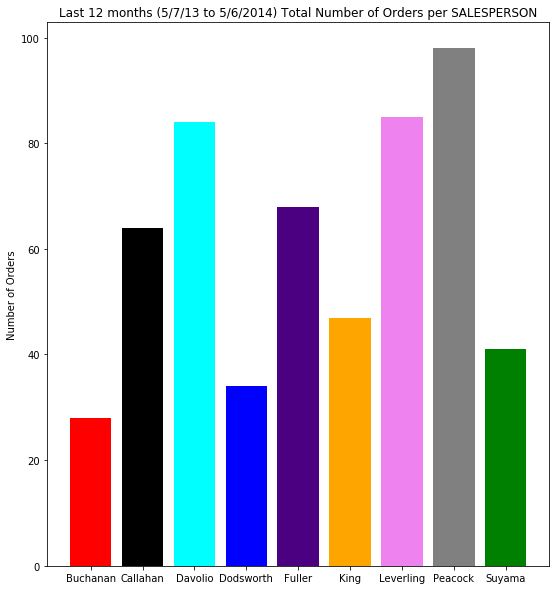

In [109]:
plt.figure(figsize=(9,10))
x=Emp_Ord_Cust_OrdDet2__TOTORDERCount_GrpbyRep2['LastName']
y=Emp_Ord_Cust_OrdDet2__TOTORDERCount_GrpbyRep2['ORDERS_by_Rep']
plt.bar(x,y,color=['red','black','cyan','blue','indigo','orange','violet','grey','green'])
plt.ylabel('Number of Orders')
plt.title('Last 12 months (5/7/13 to 5/6/2014) Total Number of Orders per SALESPERSON')
plt.show()

ANOVA assumes that the data is normally distributed, and that the samples have similar variances.  Log-transforming the data results in a more normally distributed data with similar distributions.  The distributions of the log-transformed data (shown below) are  produced with the following code:

The data is grouped by each Order with it's respective Revenue.  As a reminder, I'm using orders in the Last 12 months.  There are 549 Orders.

In [110]:
# Fitting a model of average Revenue per Customer on Salesperson LastName categories, and using statsmodels to compute
#an ANOVA table
lm_RevOrd = ols('Revenue_per_Order ~ C(LastName)', Emp_Ord_Cust_OrdDet2__Order_GrpbyRep).fit()
sm.stats.anova_lm(lm_RevOrd, typ=2)

,sum_sq,df,F,PR(>F)
C(LastName),3.354995e+07,8.0,1.155417,0.324413
Residual,1.960003e+09,540.0,NaN,NaN


/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


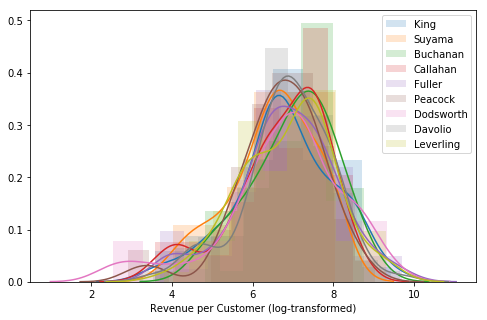

In [111]:
df_log = Emp_Ord_Cust_OrdDet2__Order_GrpbyRep
df_log['Revenue_per_Order'] = np.log(Emp_Ord_Cust_OrdDet2__Order_GrpbyRep['Revenue_per_Order'])
# Plotting the distributions for the log-transformed data
plt.figure(figsize=(8,5))
for name in set(df_log.LastName):
    name_group = df_log.loc[df_log['LastName'] == name]
    sns.distplot(name_group['Revenue_per_Order'], hist_kws=dict(alpha=0.2), label=name)
    plt.legend()
    plt.xlabel('Revenue per Customer (log-transformed)')

The log transformed data is more normal, so the ANOVA assumption of normality will be satisfied.

In [112]:
# Fitting a model of average Revenue per Customer on Salesperson LastName categories, and using statsmodels to compute
#an ANOVA table
lm_log = ols('Revenue_per_Order ~ C(LastName)',df_log).fit()
sm.stats.anova_lm(lm_log, typ=2)

,sum_sq,df,F,PR(>F)
C(LastName),7.107128,8.0,0.655074,0.731182
Residual,732.330988,540.0,NaN,NaN


In [113]:
lm_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Revenue_per_Order   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.6551
Date:                Mon, 25 Mar 2019   Prob (F-statistic):              0.731
Time:                        08:45:32   Log-Likelihood:                -858.09
No. Observations:                 549   AIC:                             1734.
Df Residuals:                     540   BIC:                             1773.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    7.0225      0.220     31.909      0.000       6.590       7.455
C(LastName)[T.Callahan]     -0.3094      0.264     -1.173      0.241      -0.828       0.209
C(LastName)[T.Davolio]      -0.1418      0.254     -0.558      0.577      -0.641       0.357
C(LastName)[T.Dodsworth]    -0.2625      0.297     -0.883      0.377      -0.846       0.321
C(LastName)[T.Fuller]       -0.1819      0.261     -0.696      0.487      -0.696       0.332
C(LastName)[T.King]         -0.2274      0.278     -0.818      0.414      -0.773       0.319
C(LastName)[T.Leverling]    -0.1538      0.254     -0.606      0.545      -0.652       0.345
C(LastName)[T.Peacock]      -0.3250      0.250     -1.302      0.193      -0.815       0.165
C(LastName)[T.Suyama]       -0.5010      0.286     -1.755      0.080      -1.062       0.060
==============================================================================
Omnibus:                       36.697   Durbin-Watson:                   1.848
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.842
Skew:                          -0.606   Prob(JB):                     3.02e-10
Kurtosis:                       3.669   Cond. No.                         14.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Next, we will see if there is a statistical difference in the Revenue of the 9 Salespeople.

/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


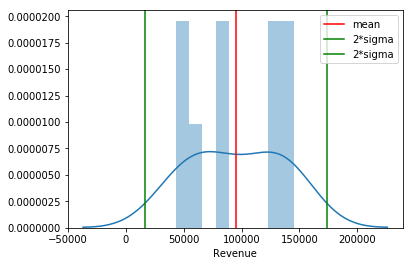

In [114]:
SalesRep_Revenue.Revenue
sns.distplot(SalesRep_Revenue.Revenue,hist=True, bins=9)
plt.axvline(SalesRep_Revenue.Revenue.mean(),color='red',label=("mean"))
sigma1=SalesRep_Revenue.Revenue.mean()+2*SalesRep_Revenue.Revenue.std()
sigma2=SalesRep_Revenue.Revenue.mean()-2*SalesRep_Revenue.Revenue.std()
plt.axvline(sigma1,color='green',label=("2*sigma"))
plt.axvline(sigma2,color='green',label=("2*sigma"))
plt.legend()

In [115]:
stats.normaltest(SalesRep_Revenue.Revenue)

/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  "anyway, n=%i" % int(n))


NormaltestResult(statistic=2.8344917302753325, pvalue=0.24238064747155966)

The pvalue is >.05, so we "fail to reject" that the null hypothesis that the data is normally distributed.

Next, we will see if there is a statistical difference in the Number of Orders of the 9 Salespeople.

/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


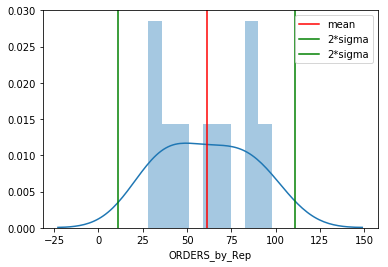

In [116]:
sns.distplot(Emp_Ord_Cust_OrdDet2__TOTORDERCount_GrpbyRep2.ORDERS_by_Rep,hist=True,bins=9)
plt.axvline(Emp_Ord_Cust_OrdDet2__TOTORDERCount_GrpbyRep2.ORDERS_by_Rep.mean(),color='red',label=("mean"))
sigma3=Emp_Ord_Cust_OrdDet2__TOTORDERCount_GrpbyRep2.ORDERS_by_Rep.mean()+2*Emp_Ord_Cust_OrdDet2__TOTORDERCount_GrpbyRep2.ORDERS_by_Rep.std()
sigma4=Emp_Ord_Cust_OrdDet2__TOTORDERCount_GrpbyRep2.ORDERS_by_Rep.mean()-2*Emp_Ord_Cust_OrdDet2__TOTORDERCount_GrpbyRep2.ORDERS_by_Rep.std()
plt.axvline(sigma3,color='green',label=("2*sigma"))
plt.axvline(sigma4,color='green',label=("2*sigma"))
plt.legend()

In [117]:
stats.normaltest(Emp_Ord_Cust_OrdDet2__TOTORDERCount_GrpbyRep2.ORDERS_by_Rep)

/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  "anyway, n=%i" % int(n))


NormaltestResult(statistic=1.571433098794866, pvalue=0.4557929865559469)

The pvalue is >.05, so we "fail to reject" that the null hypothesis that the data is normally distributed.

CONCULSION:  There's no 'statistical difference between salespeople in terms of Revenue and Number of Orders.  I assume that there's normal distribution of the mean and standard deviation of both the Revenue and Number of Orders' samples is visualized in the seaborn plots above.  A normal distribution curve plotted.  The green lines represent 2 standard deviations which would be an approximation of 95% Probability Mass Function.  

All data points fall within the 95%, therefore the pvalue is >.05 and we FAIL TO REJECT the NULL Hypothesis.


XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

QUESTION 5: Do we grow by focusing our efforts on underperforming regions? Or do we expand into other Regions?

    NULL HYPOTHESES:  All geographical areas are ordering the same amount from us (Northwinds).  
    
    ALTERNATIVE HYPOTHESIS:  Areas are different and there's an opportunity to grow in existing territories and/or expand into others.
    
    TWO-TAILED TEST & ALPHA = .05

First, we will start by mapping our current customers, of which there are 88.

To map the cities, I'm going to use Geopy, so I need to check the spelling of the cities and ensure that Geopy can recognize the city names in the city columns.  One city name was corrected in the cell below. 

In [118]:
Customer['City'][9]=Customer['City'][9].replace('Tsawassen',"Tsawwassen")

In [119]:
Customer.head(5)

,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,Western Europe,12209,Germany,030-0074321,030-0076545
1,ANATR,Ana Trujillo Emparedados y helados,Ana Trujillo,Owner,Avda. de la Constitución 2222,México D.F.,Central America,05021,Mexico,(5) 555-4729,(5) 555-3745
2,ANTON,Antonio Moreno Taquería,Antonio Moreno,Owner,Mataderos 2312,México D.F.,Central America,05023,Mexico,(5) 555-3932,None
3,AROUT,Around the Horn,Thomas Hardy,Sales Representative,120 Hanover Sq.,London,British Isles,WA1 1DP,UK,(171) 555-7788,(171) 555-6750
4,BERGS,Berglunds snabbköp,Christina Berglund,Order Administrator,Berguvsvägen 8,Luleå,Northern Europe,S-958 22,Sweden,0921-12 34 65,0921-12 34 67


Here, I'll use Geopy to find the latitude and longitude for each customer location.

In [123]:
from geopy.geocoders import Nominatim 
geolocator = Nominatim(user_agent="specify_your_app_name_here")

from geopy.extra.rate_limiter import RateLimiter 
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1) 
lat=[] 
long=[] 
for i in range(len(Customer.City)):
    location = geolocator.geocode(Customer['City'][i]) 
    lat.append(location.latitude) 
    long.append(location.longitude)

GeocoderTimedOut: Service timed out

In [122]:
lat2=[]
long2=[]
for i in range(len(Employee.City)):            
    location = geolocator.geocode(Employee['City'][i])
    lat2.append(location.latitude)
    long2.append(location.longitude)

GeocoderTimedOut: Service timed out

Below, I'm using FOLIUM to "map" and then "mark" each customer location.  This gives an overview of the locations of our current customers.  Then, we can visually see if there are areas open geographically.

In [124]:
import folium
m=folium.Map(location=[20, 0], tiles="Mapbox Bright", zoom_start=2)
for i in range(len(long)):
    folium.Marker([lat[i], long[i]],popup=Customer['City'][i],icon=folium.Icon(color='blue')).add_to(m)
for i in range(len(long2)):
    folium.Marker([lat2[i], long2[i]],popup=Employee['LastName'][i],icon=folium.Icon(color='red')).add_to(m)    
m

#folium.Marker([lat, lon], popup=str(name)+': '+color+'-'+str(clname), icon=folium.Icon(color=color))

Visually, the map shows a concentration of customers in the US Pacific Northwest and in Western Europe.  This makes sense, since the salespeople are physically located in Seattle, WA and London.

Next, we'll see how many: 
1.  Regions
2.  Average Countries per Region
3.  Regions & Countries per Salesperson
4.  Average Customers per Region & Countries
5.  Average Orders per Region & Country in the Last 12 Months (5/7/13 to 5/6/14)
6.  Average Revenue per Customer per Country in the last 12 Months (5/7/13 to 5/6/14)


7.  Average Revenue per Order per Country 
8.  Average Quantity of Products per Order per Country
9.  Sales per Capita
    --new column with population of country
    --separate into subregions and determine per capita sales by state
10.  grow into neighboring state or those areas that differ per capita

In [125]:
len(Customer), len(Order[Order['OrderDate']>=dt.datetime(2013,5,6)]),len(Emp_Ord_Cust_OrDet_Last12mos)

(91, 550, 1410)

In [126]:
Emp_Ord_Cust_OrDet_Last12mos.head(3)

,Id_x,Id_x,LastName,FirstName,Title,CustomerId,OrderDate,UnitPrice,Quantity,Discount,Revenue
105,1,RICSU,Davolio,Nancy,Sales Representative,RICSU,2013-05-14,12.50,30,0.0,375.0
106,1,RICSU,Davolio,Nancy,Sales Representative,RICSU,2013-05-14,53.00,6,0.0,318.0
107,1,RICSU,Davolio,Nancy,Sales Representative,RICSU,2013-05-14,13.25,20,0.0,265.0


Northwinds sells in 4 Regions, split into 53 Territories selling to 91 Customers.  In the Last 12 months (5/7/2013 to 5/6/2014), the company has had 550 orders with 1410 "Order Detail Lines" worth $856,885.

I'm going to do some EDA to analyze each of the Territories within the Regions.  I want to know how the Regions and Territories are defined.  Where areas are be served and what areas are not being served?

In [127]:
Territory.head(2)

,Id,TerritoryDescription,RegionId
0,01581,Westboro,1
1,01730,Bedford,1


In [128]:
Region.head(2)

,Id,RegionDescription
0,1,Eastern
1,2,Western


In [129]:
EmployeeTerritory.head(2)

,Id,EmployeeId,TerritoryId
0,1/06897,1,06897
1,1/19713,1,19713


In my opinion, the detail found in Region, Territories, and Territory Description Tables is not descriptive.  So, I'll use the information in the Customer Table to segregate customers into Geographical Areas.

And, we are evaluating orders in the last 12 months, so I'll slice by date.

In [130]:
Emp_Ord_Cust_OrDet=Employee.merge(Order, left_on='Id',right_on='EmployeeId',how='left').merge(Customer, left_on=
    'CustomerId',right_on='Id', how='left').merge(OrderDetail, left_on='Id_y', right_on='OrderId', how='left')
#Emp_Ord_Cust_OrdDet.columns
Emp_Ord_Cust_OrDet3=Emp_Ord_Cust_OrDet[['LastName','FirstName','Title','City_x','Region_x','CustomerId','OrderDate',\
    'ShipCity', 'ShipRegion','ShipCountry','OrderId', 'UnitPrice', 'Quantity','Discount']]
Emp_Ord_Cust_OrDet4=Emp_Ord_Cust_OrDet3[Emp_Ord_Cust_OrDet3['OrderDate']>=dt.datetime(2013,5,6)]
Emp_Ord_Cust_OrDet4.head()

,LastName,FirstName,Title,City_x,Region_x,CustomerId,OrderDate,ShipCity,ShipRegion,ShipCountry,OrderId,UnitPrice,Quantity,Discount
105,Davolio,Nancy,Sales Representative,Seattle,North America,RICSU,2013-05-14,Genève,Western Europe,Switzerland,10537,12.50,30,0.0
106,Davolio,Nancy,Sales Representative,Seattle,North America,RICSU,2013-05-14,Genève,Western Europe,Switzerland,10537,53.00,6,0.0
107,Davolio,Nancy,Sales Representative,Seattle,North America,RICSU,2013-05-14,Genève,Western Europe,Switzerland,10537,13.25,20,0.0
108,Davolio,Nancy,Sales Representative,Seattle,North America,RICSU,2013-05-14,Genève,Western Europe,Switzerland,10537,34.80,21,0.0
109,Davolio,Nancy,Sales Representative,Seattle,North America,RICSU,2013-05-14,Genève,Western Europe,Switzerland,10537,15.00,9,0.0


In my EDA, it was discovered that 2 of the customers has NaN in some of the data, so I filled those elements with the correct value.

Next, I'll groupby Customer, Region, Country to see if there's any regional tendencies.

In [131]:
print('Northwinds sells into {} countries, this table show the number of countries serviced by each salesperson'.format(len(Emp_Ord_Cust_OrDet4.ShipCountry.unique())))
Country_Grp2

Northwinds sells into 21 countries, this table show the number of countries serviced by each salesperson


,LastName,City_x,Territory_Countries
0,Buchanan,London,11
1,Callahan,Seattle,16
2,Davolio,Seattle,21
3,Dodsworth,London,16
4,Fuller,Tacoma,18
5,King,London,19
6,Leverling,Kirkland,18
7,Peacock,Redmond,19
8,Suyama,London,15


In [132]:
print('Northwinds sells into {} regions, this table show the number of countries serviced by each salesperson'.format(len(Emp_Ord_Cust_OrDet4.ShipRegion.unique())))
Region_Grp2

Northwinds sells into 9 regions, this table show the number of countries serviced by each salesperson


,LastName,City_x,Region_x,Territory_Regions
0,Buchanan,London,British Isles,7
1,Callahan,Seattle,North America,7
2,Davolio,Seattle,North America,9
3,Dodsworth,London,British Isles,7
4,Fuller,Tacoma,North America,8
5,King,London,British Isles,8
6,Leverling,Kirkland,North America,8
7,Peacock,Redmond,North America,9
8,Suyama,London,British Isles,8


It appears that each salesperson sells into most of the countries and regions.  There are not sales territory boundaries.  All salespeople are based in Washington State or London.

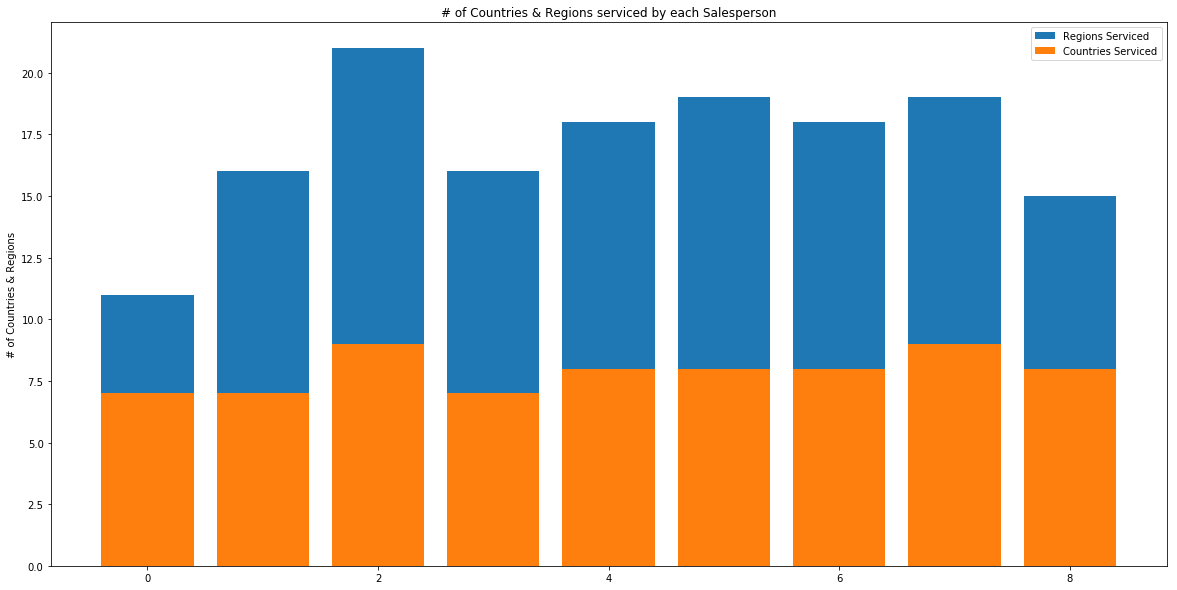

In [133]:
plt.figure(figsize=(20,10))
x=Region_Grp2.index
y1=Country_Grp2['Territory_Countries']
y2=Region_Grp2['Territory_Regions']
plt.bar(x,y1,label='Regions Serviced')
plt.bar(x,y2,label="Countries Serviced")
plt.ylabel('# of Countries & Regions')
plt.title('# of Countries & Regions serviced by each Salesperson')
plt.legend()
plt.show()

Next, I'll calculate the number of customers in each Country and Region

In [134]:
print('Northwinds sells into {} regions, this table show the number of customers in each of the Regions.'.\
    format(len(Emp_Ord_Cust_OrDet4.ShipRegion.unique())))
Region_Customer_Grp=Emp_Ord_Cust_OrDet4.groupby(['ShipRegion','CustomerId'])['OrderId'].size().to_frame\
    ('Order_Lines').reset_index()
Region_Customer_Grp2=Region_Customer_Grp.groupby(['ShipRegion'])['CustomerId'].size().to_frame\
   ('Num_Customers').reset_index()
Region_Customer_Grp2

Northwinds sells into 9 regions, this table show the number of customers in each of the Regions.


,ShipRegion,Num_Customers
0,British Isles,8
1,Central America,4
2,Eastern Europe,1
3,North America,16
4,Northern Europe,4
5,Scandinavia,3
6,South America,16
7,Southern Europe,9
8,Western Europe,27


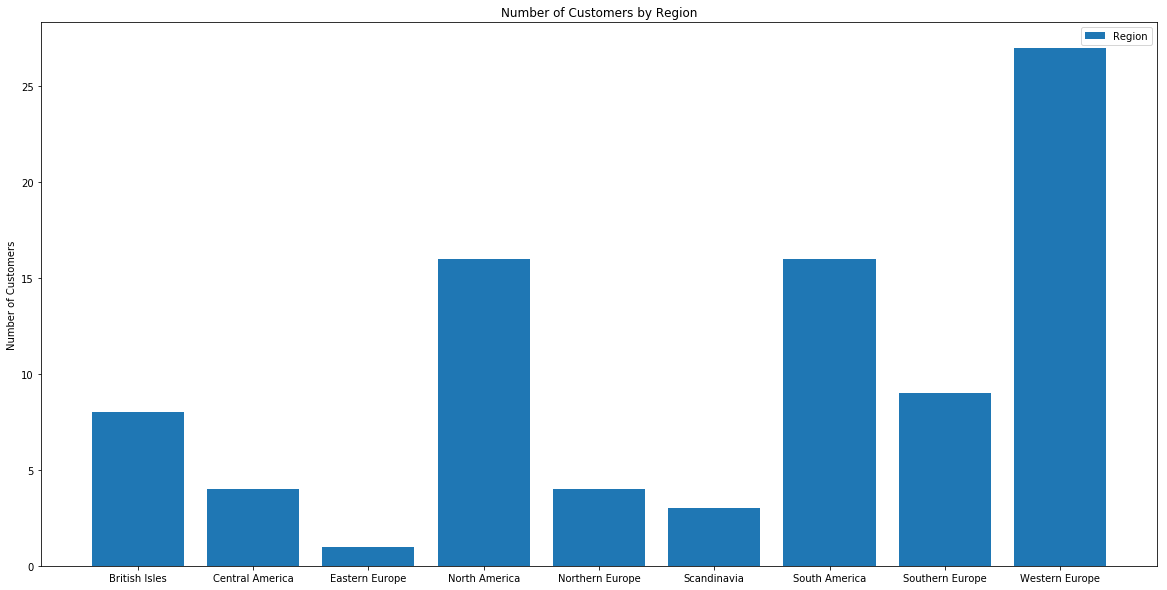

In [135]:
plt.figure(figsize=(20,10))
x=Region_Customer_Grp2.ShipRegion
y=Region_Customer_Grp2['Num_Customers']
plt.bar(x,y,label='Region')
plt.ylabel('Number of Customers')
plt.title('Number of Customers by Region')
plt.legend()
plt.show()

Next, we'll analyze the number of customers by Country.

In [136]:
print('Northwinds sells into {} regions, this table show the number of customers in each of the Regions.'.\
    format(len(Emp_Ord_Cust_OrDet4.ShipCountry.unique())))
Country_Customer_Grp=Emp_Ord_Cust_OrDet4.groupby(['ShipCountry','CustomerId'])['OrderId'].size().to_frame\
    ('Order_Lines').reset_index()
Country_Customer_Grp2=Country_Customer_Grp.groupby(['ShipCountry'])['CustomerId'].size().to_frame\
      ('Num_Customers').reset_index()
Country_Customer_Grp2.head(3)

Northwinds sells into 21 regions, this table show the number of customers in each of the Regions.


,ShipCountry,Num_Customers
0,Argentina,3
1,Austria,2
2,Belgium,2


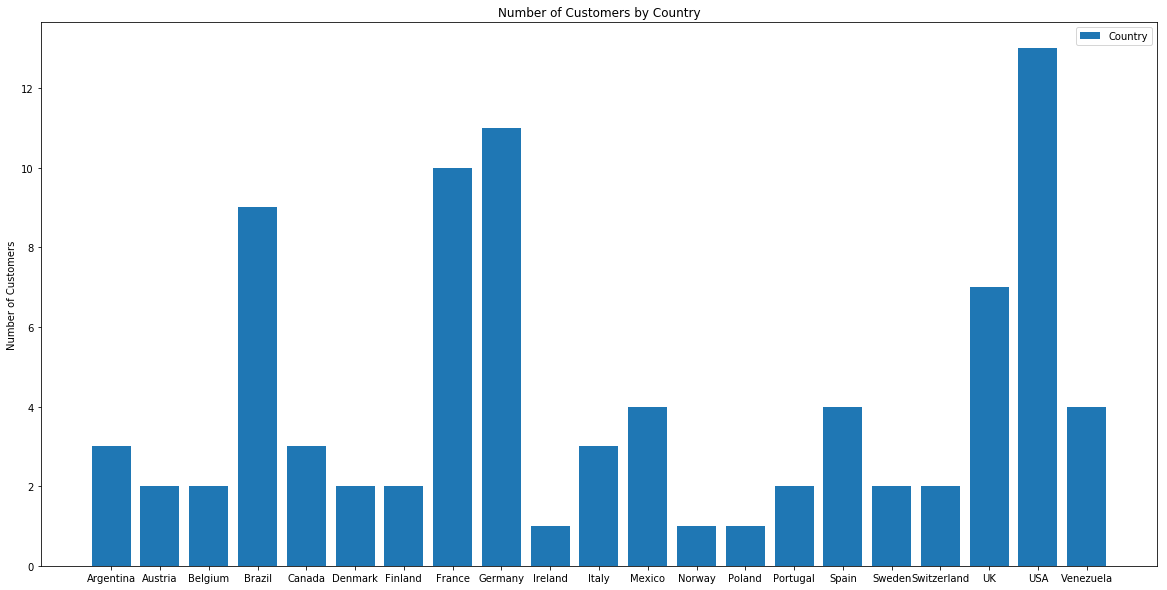

In [137]:
plt.figure(figsize=(20,10))
x=Country_Customer_Grp2.ShipCountry
y=Country_Customer_Grp2['Num_Customers']
plt.bar(x,y,label='Country')
plt.ylabel('Number of Customers')
plt.title('Number of Customers by Country')
plt.legend()
plt.show()

Next, we'll analyze the number of orders by Region.

In [138]:
print('Northwinds sells into {} regions, this table show the number of customers in each of the Regions.'.\
    format(len(Emp_Ord_Cust_OrDet4.ShipRegion.unique())))
Region_Order_Grp=Emp_Ord_Cust_OrDet4.groupby(['ShipRegion','OrderId'])['OrderId'].size().to_frame\
    ('Order_Lines').reset_index()
Region_Order_Grp2=Region_Order_Grp.groupby(['ShipRegion'])['OrderId'].size().to_frame\
     ('Num_Orders').reset_index()
Region_Order_Grp2

Northwinds sells into 9 regions, this table show the number of customers in each of the Regions.


,ShipRegion,Num_Orders
0,British Isles,47
1,Central America,15
2,Eastern Europe,6
3,North America,105
4,Northern Europe,39
5,Scandinavia,17
6,South America,101
7,Southern Europe,41
8,Western Europe,179


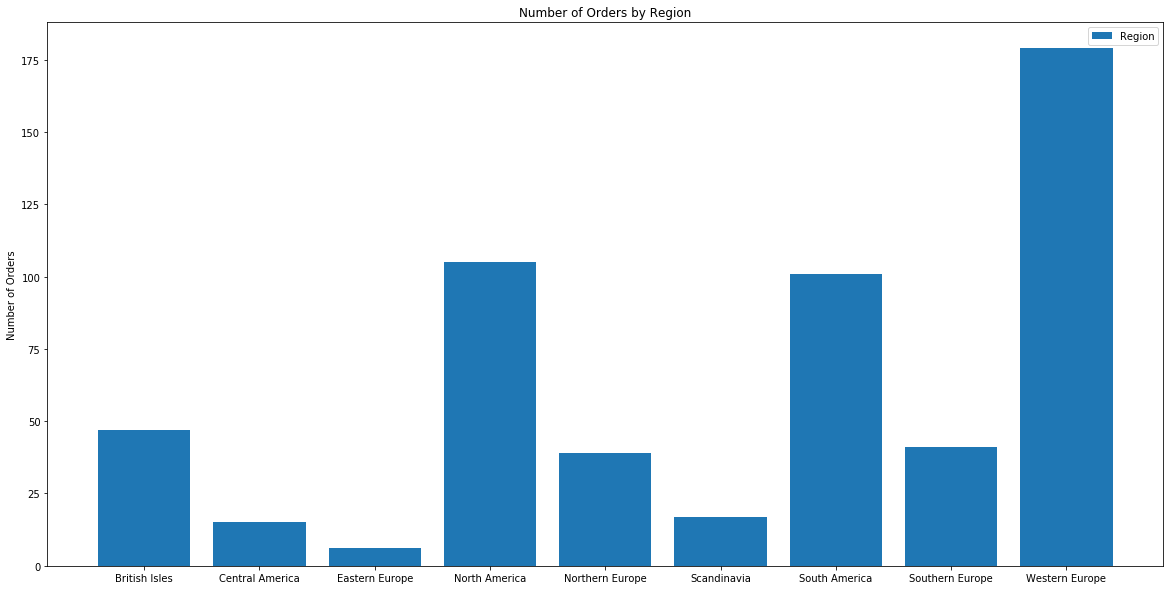

In [139]:
plt.figure(figsize=(20,10))
x=Region_Order_Grp2.ShipRegion
y=Region_Order_Grp2['Num_Orders']
plt.bar(x,y,label='Region')
plt.ylabel('Number of Orders')
plt.title('Number of Orders by Region')
plt.legend()
plt.show()

Next, we'll analyze the number of orders by Country.

In [140]:
print('Northwinds sells into {} regions, this table show the number of customers in each of the Country.'.\
    format(len(Emp_Ord_Cust_OrDet4.ShipCountry.unique())))
Country_Order_Grp=Emp_Ord_Cust_OrDet4.groupby(['ShipCountry','CustomerId'])['OrderId'].size().to_frame\
    ('Order_Lines').reset_index()
Country_Order_Grp2=Country_Order_Grp.groupby(['ShipCountry'])['Order_Lines'].sum().to_frame\
      ('Num_Orders').reset_index()
Country_Order_Grp3=Country_Order_Grp2.sort_values('Num_Orders',ascending=False).reset_index()
Country_Order_Grp3.head(10)

Northwinds sells into 21 regions, this table show the number of customers in each of the Country.


,index,ShipCountry,Num_Orders
0,19,USA,262
1,8,Germany,210
2,3,Brazil,134
3,7,France,110
4,18,UK,87
5,1,Austria,79
6,20,Venezuela,76
7,16,Sweden,67
8,4,Canada,43
9,11,Mexico,40


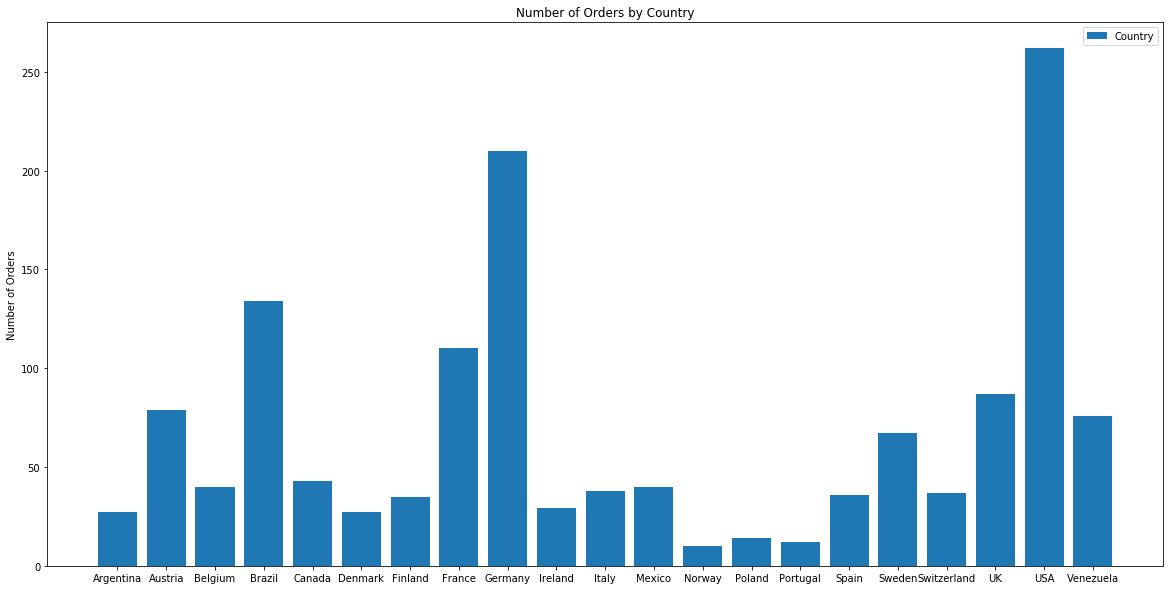

In [141]:
plt.figure(figsize=(20,10))
x=Country_Order_Grp2.ShipCountry
y=Country_Order_Grp2['Num_Orders']
plt.bar(x,y,label='Country')
plt.ylabel('Number of Orders')
plt.title('Number of Orders by Country')
plt.legend()
plt.show()

Next, I'll calculate Average Revenue per Customer per Country in the last 12 Months (5/7/13 to 5/6/14)

In [142]:
Emp_Ord_Cust_OrDet4["Revenue"]=Emp_Ord_Cust_OrDet4["UnitPrice"]*Emp_Ord_Cust_OrDet4["Quantity"]*\
                                        (1-Emp_Ord_Cust_OrDet4["Discount"])
Emp_Ord_Cust_OrDet4.columns

/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Index(['LastName', 'FirstName', 'Title', 'City_x', 'Region_x', 'CustomerId',
       'OrderDate', 'ShipCity', 'ShipRegion', 'ShipCountry', 'OrderId',
       'UnitPrice', 'Quantity', 'Discount', 'Revenue'],
      dtype='object')

In [143]:
Rev_Country_Customer=Emp_Ord_Cust_OrDet4.groupby(['ShipCountry','CustomerId','OrderId'])['Revenue'].sum().to_frame\
    ('Revenue').reset_index()
Rev_Country_Customer2=Rev_Country_Customer.groupby(['ShipCountry','CustomerId'])['Revenue'].mean().to_frame\
    ('Avg_Rev').reset_index()

In [144]:
# Fitting a model of average Revenue per Customer on Countrt categories, and using statsmodels to compute
#an ANOVA table
lm = ols('Avg_Rev ~ C(ShipCountry)', Rev_Country_Customer2).fit()
table = sm.stats.anova_lm(lm, typ=2)
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Avg_Rev   R-squared:                       0.282
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     1.313
Date:                Mon, 25 Mar 2019   Prob (F-statistic):              0.202
Time:                        08:49:34   Log-Likelihood:                -703.53
No. Observations:                  88   AIC:                             1449.
Df Residuals:                      67   BIC:                             1501.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                       567.7617    474.736      1.196      0.236    -379.815    1515.338
C(ShipCountry)[T.Austria]      2285.9432    750.623      3.045      0.003     787.693    3784.194
C(ShipCountry)[T.Belgium]       961.4294    750.623      1.281      0.205    -536.821    2459.680
C(ShipCountry)[T.Brazil]        513.6137    548.178      0.937      0.352    -580.554    1607.781
C(ShipCountry)[T.Canada]        623.2661    671.378      0.928      0.357    -716.810    1963.342
C(ShipCountry)[T.Denmark]       630.2309    750.623      0.840      0.404    -868.020    2128.481
C(ShipCountry)[T.Finland]       262.1943    750.623      0.349      0.728   -1236.056    1760.445
C(ShipCountry)[T.France]        403.1001    541.282      0.745      0.459    -677.304    1483.504
C(ShipCountry)[T.Germany]       930.4831    535.574      1.737      0.087    -138.528    1999.494
C(ShipCountry)[T.Ireland]      2612.7474    949.472      2.752      0.008     717.594    4507.901
C(ShipCountry)[T.Italy]          10.9868    671.378      0.016      0.987   -1329.089    1351.063
C(ShipCountry)[T.Mexico]        184.7266    628.017      0.294      0.770   -1068.800    1438.253
C(ShipCountry)[T.Norway]        551.4258    949.472      0.581      0.563   -1343.728    2446.579
C(ShipCountry)[T.Poland]        -55.6033    949.472     -0.059      0.953   -1950.757    1839.550
C(ShipCountry)[T.Portugal]     1155.9805    750.623      1.540      0.128    -342.270    2654.231
C(ShipCountry)[T.Spain]         246.5686    628.017      0.393      0.696   -1006.958    1500.095
C(ShipCountry)[T.Sweden]       1052.4562    750.623      1.402      0.165    -445.794    2550.707
C(ShipCountry)[T.Switzerland]  1190.5143    750.623      1.586      0.117    -307.736    2688.765
C(ShipCountry)[T.UK]            463.1906    567.418      0.816      0.417    -669.380    1595.761
C(ShipCountry)[T.USA]           748.3322    526.672      1.421      0.160    -302.910    1799.574
C(ShipCountry)[T.Venezuela]     466.2152    628.017      0.742      0.460    -787.311    1719.742
==============================================================================
Omnibus:                       35.195   Durbin-Watson:                   2.152
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               73.734
Skew:                           1.499   Prob(JB):                     9.75e-17
Kurtosis:                       6.335   Cond. No.                         26.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The pvalue is <.05 for Austria, so we REJECT the NULL HYPOTHESIS that the Average Customer Revenues differ by Country.  Therefore, Average Customer Revenues in for all other Countries are Statistically Similar.

Next, I'll calculate the Mean of the Average Customer Revenues for each individual country and plot.

In [145]:
Rev_Country_Customer3=Rev_Country_Customer2.groupby(['ShipCountry'])['Avg_Rev'].mean().to_frame\
    ('Mean_Avg_Rev').reset_index()
Rev_Country_Customer3.head()

,ShipCountry,Mean_Avg_Rev
0,Argentina,567.761667
1,Austria,2853.704873
2,Belgium,1529.191071
3,Brazil,1081.375384
4,Canada,1191.027778


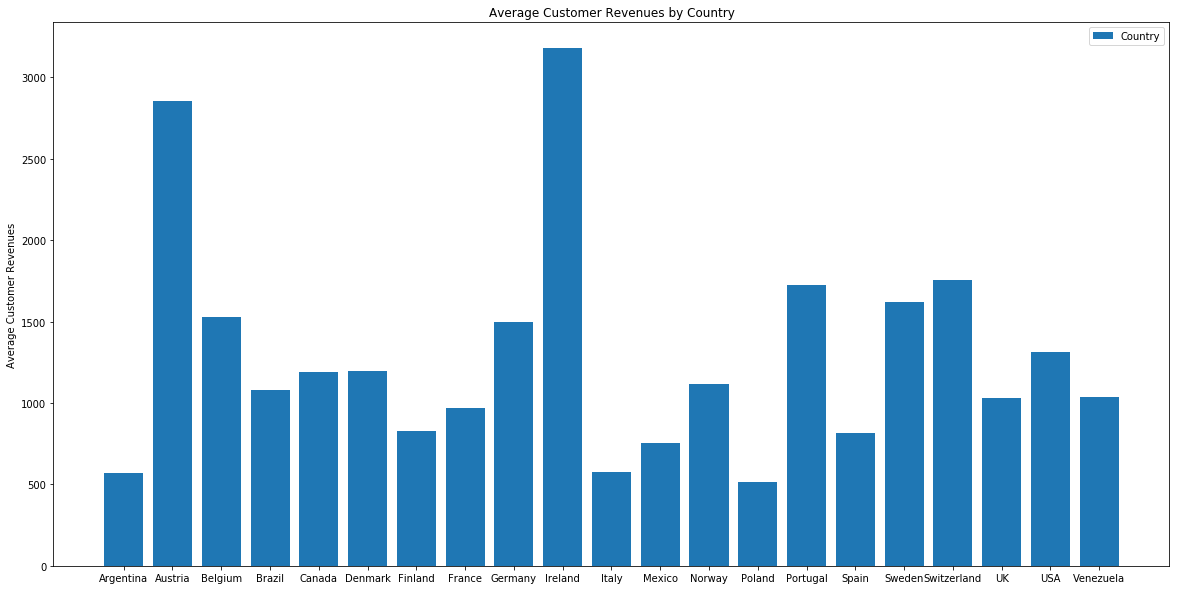

In [146]:
plt.figure(figsize=(20,10))
x=Rev_Country_Customer3.ShipCountry
y=Rev_Country_Customer3['Mean_Avg_Rev']
plt.bar(x,y,label='Country')
plt.ylabel('Average Customer Revenues')
plt.title('Average Customer Revenues by Country')
plt.legend()
plt.show()

/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


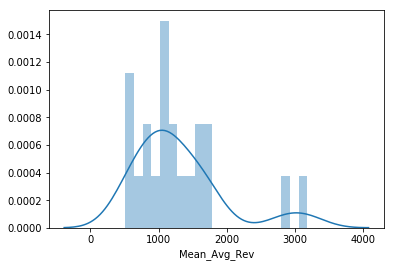

In [147]:
sns.distplot(Rev_Country_Customer3['Mean_Avg_Rev'], bins=21)

Next, I'll analyze the AVERAGE REVENUE ORDER PER COUNTRY to see if there's a statistical difference in certain countries.

In [148]:
Rev_Country_Order=Emp_Ord_Cust_OrDet4.groupby(['ShipCountry','OrderId'])['Revenue'].sum().to_frame\
    ('Revenue_per_Order').reset_index()
Rev_Country_Order2=Rev_Country_Order.groupby(['ShipCountry'])['Revenue_per_Order'].mean().to_frame\
    ('Avg_Rev_per_Order').reset_index()
Rev_Country_Order.std()

OrderId               158.915596
Revenue_per_Order    1906.233914
dtype: float64

In [149]:
Rev_Country_Order

,ShipCountry,OrderId,Revenue_per_Order
0,Argentina,10531,110.0000
1,Argentina,10716,706.0000
2,Argentina,10782,12.5000
3,Argentina,10819,477.0000
4,Argentina,10828,932.0000
5,Argentina,10881,150.0000
6,Argentina,10898,30.0000
7,Argentina,10916,686.7000
8,Argentina,10937,644.8000
9,Argentina,10958,781.0000


In [150]:
# Fitting a model of average Revenue per Order by Country categories, and using statsmodels to compute
#an ANOVA table
lm = ols('Revenue_per_Order ~ C(ShipCountry)', Rev_Country_Order).fit()
table = sm.stats.anova_lm(lm, typ=1)
print(table)

                   df        sum_sq       mean_sq         F        PR(>F)
C(ShipCountry)   20.0  2.379824e+08  1.189912e+07  3.582739  3.407769e-07
Residual        529.0  1.756934e+09  3.321236e+06       NaN           NaN


In [151]:
mod = MultiComparison(Rev_Country_Order.Revenue_per_Order, Rev_Country_Order.ShipCountry)
print (mod.tukeyhsd())

      Multiple Comparison of Means - Tukey HSD,FWER=0.05      
   group1      group2    meandiff    lower      upper   reject
--------------------------------------------------------------
 Argentina    Austria   2748.6267   512.8353   4984.418  True 
 Argentina    Belgium    980.6526  -1537.7626 3499.0678 False 
 Argentina     Brazil    756.2863  -1250.1466 2762.7193 False 
 Argentina     Canada    985.5115  -1394.363  3365.3861 False 
 Argentina    Denmark    682.4017  -1882.2268 3247.0303 False 
 Argentina    Finland    252.3148  -2312.3137 2816.9434 False 
 Argentina     France    431.965   -1617.0077 2480.9377 False 
 Argentina    Germany   1513.2221  -442.0443  3468.4886 False 
 Argentina    Ireland   2631.9706   -46.6965  5310.6378 False 
 Argentina     Italy     61.6878   -2267.7518 2391.1273 False 
 Argentina     Mexico    246.7725  -2230.894  2724.4391 False 
 Argentina     Norway    570.649   -3167.9074 4309.2055 False 
 Argentina     Poland    -36.3801  -3263.4669 3190.7067

The Tukey Pairwise test shows that, given an alpha=.05, that the following pairs of Countries have statistically significant mean "Revenue per Orders".

Austria is different from:  Argentina, Brazil, Finland, France, Italy, Mexico, Spain, UK, Venezuela
Ireland is different from:  France, Italy



CONCLUSION:  I REJECT THE NULL HYPOTHESIS that all countries are the same in terms of "REVENUE PER ORDER.  Austria and Ireland are statiscally different than 2 or more other countries to the right (greater) of the mean.  BUSINESS INSIGHT:  There's an opportunity to increase "REVENUE PER ORDER" with NEW customers in France and Italy.

France and Italy are statiscally different than 2 or more other countries to the left (less) of the mean.  BUSINESS INSIGHT:  There's an opportunity to increase "REVENUE PER ORDER" with CURRENT customers in France and Italy.

In [152]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Revenue_per_Order   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     3.583
Date:                Mon, 25 Mar 2019   Prob (F-statistic):           3.41e-07
Time:                        08:49:56   Log-Likelihood:                -4899.1
No. Observations:                 550   AIC:                             9840.
Df Residuals:                     529   BIC:                             9931.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                       548.5385    505.450      1.085      0.278    -444.397    1541.474
C(ShipCountry)[T.Austria]      2748.6267    623.161      4.411      0.000    1524.453    3972.800
C(ShipCountry)[T.Belgium]       980.6526    701.934      1.397      0.163    -398.267    2359.572
C(ShipCountry)[T.Brazil]        756.2863    559.234      1.352      0.177    -342.305    1854.878
C(ShipCountry)[T.Canada]        985.5115    663.320      1.486      0.138    -317.552    2288.575
C(ShipCountry)[T.Denmark]       682.4017    714.814      0.955      0.340    -721.821    2086.625
C(ShipCountry)[T.Finland]       252.3148    714.814      0.353      0.724   -1151.908    1656.538
C(ShipCountry)[T.France]        431.9650    571.090      0.756      0.450    -689.919    1553.849
C(ShipCountry)[T.Germany]      1513.2221    544.973      2.777      0.006     442.646    2583.798
C(ShipCountry)[T.Ireland]      2631.9706    746.599      3.525      0.000    1165.308    4098.634
C(ShipCountry)[T.Italy]          61.6878    649.262      0.095      0.924   -1213.761    1337.137
C(ShipCountry)[T.Mexico]        246.7725    690.576      0.357      0.721   -1109.836    1603.381
C(ShipCountry)[T.Norway]        570.6490   1042.012      0.548      0.584   -1476.340    2617.638
C(ShipCountry)[T.Poland]        -36.3801    899.455     -0.040      0.968   -1803.322    1730.562
C(ShipCountry)[T.Portugal]      629.1090    959.024      0.656      0.512   -1254.854    2513.072
C(ShipCountry)[T.Spain]         368.2615    680.483      0.541      0.589    -968.519    1705.042
C(ShipCountry)[T.Sweden]       1092.4402    619.047      1.765      0.078    -123.653    2308.533
C(ShipCountry)[T.Switzerland]  1229.6261    714.814      1.720      0.086    -174.597    2633.849
C(ShipCountry)[T.UK]            553.1732    589.692      0.938      0.349    -605.252    1711.598
C(ShipCountry)[T.USA]          1474.0039    541.899      2.720      0.007     409.465    2538.543
C(ShipCountry)[T.Venezuela]     683.0332    605.134      1.129      0.260    -505.728    1871.795
==============================================================================
Omnibus:                      463.228   Durbin-Watson:                   2.111
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11069.013
Skew:                           3.623   Prob(JB):                         0.00
Kurtosis:                      23.749   Cond. No.                         31.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

I'm interested in countries that are statistically different.   so that This is desired, because I want to identify which countries have the most potential of increasing their "Revenue per Order" toward the mean.The pvalue is <.05, so the NULL HYPOTHESIS IS REJECTED.  The Revenue per Order is not the same for different countries.  Next, I'll identify which countries are different and have a pvalue <.05 and fall to the LEFT of F-statistic.  This is desired, because I want to identify which countries have the most potential of increasing their "Revenue per Order" toward the mean.

In [153]:
Rev_Country_Order2=Rev_Country_Order.groupby(['ShipCountry'])['Revenue_per_Order'].mean().to_frame\
    ('Avg_Rev_per_Order').reset_index()
Rev_Country_Order2.std()

Avg_Rev_per_Order    754.486571
dtype: float64

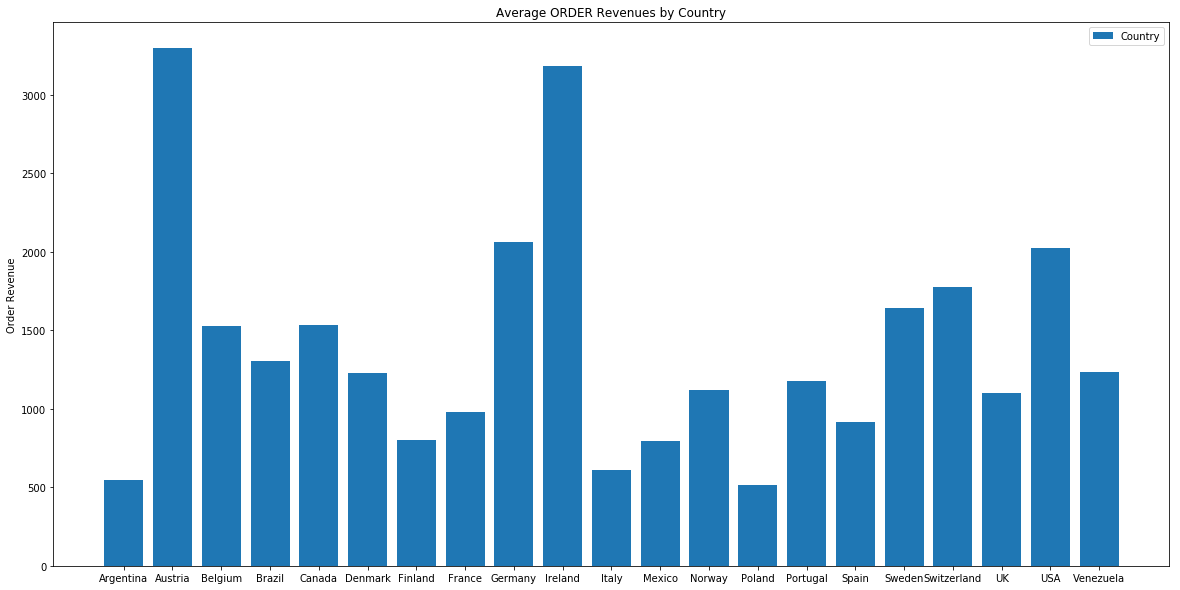

In [154]:
plt.figure(figsize=(20,10))
x=Rev_Country_Order2.ShipCountry
y=Rev_Country_Order2['Avg_Rev_per_Order']
plt.bar(x,y,label='Country')
plt.ylabel('Order Revenue')
plt.title('Average ORDER Revenues by Country')
plt.legend()
plt.show()

AUSTRIA, IRELAND, GERMANY, AND USA are STATISCALLY different in terms of Average ORDER REVENUES (DOLLAR AMOUNT) by Country.  THE NULL HYPOSTHESIS IS REJECTED in these terms.

/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


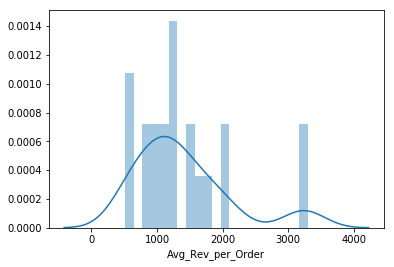

In [155]:
sns.distplot(Rev_Country_Order2['Avg_Rev_per_Order'], bins=21)

*EXECUTIVE SUMMARY******************EXECUTIVE SUMMARY*******************EXECUTIVE SUMMARY

CONCLUSION: I REJECT THE NULL HYPOTHESIS that all countries are the same in terms of "REVENUE PER ORDER. Austria and Ireland are statiscally different than 2 or more other countries to the right (greater) of the mean. BUSINESS INSIGHT: There's an opportunity to increase "REVENUE PER ORDER" with NEW customers in France and Italy.

France and Italy are statiscally different than 2 or more other countries to the left (less) of the mean. BUSINESS INSIGHT: There's an opportunity to increase "REVENUE PER ORDER" with CURRENT customers in France and Italy.

Next steps would be to analyze:
    
    -Average Quantity of Products per Order per Country
    -Sales per Capita (new column with population of country) 
    -separate into subregions and determine per capita sales by state to determine if it makes business sense to grow into neighboring state/subregion for those areas that differ per capita